# Scanning the MIRI fringes can tell us about the local properties of the MIRI SW detector
Here we attempt to fit the fringes with an "optimized" transmittance function. We do this by scanning through the fringe transmission profile, with a scan width being equal to the period of the fringes. For practical reasons the analysis is done in wavenumber space (we help ourselves with the fact that, for a plane-parallel system, the distance between etalon lines should be constant in wavenumber).

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import (savgol_filter,medfilt)
from scipy.interpolate import (InterpolatedUnivariateSpline,interp1d)
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

We load the images for one band of the MRS for different kinds of sources, including: 
* MTS 800K BB extended source
* MTS 800K BB extended source observed through 100micron pinhole 
  
Additionally the pixel-to-wavelength calibration map, the MRS spectral resolution table, and the pixel-to-along-slice position map are imported.

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band = '1A'
ext_source_sci,ext_source_bkg           = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K')
point_source_sci_p1,point_source_bkg_p1 = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='middle',pointing='P1')

# Get wavelength calibration pixel map
d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
lambdaMap = d2cMaps['lambdaMap']
wvnrMap   = 1./(lambdaMap/10000.)
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

# Get spectral resolution table
specres_table = funcs.get_cdps(cdpDir=cdpDir,band=band)[4]

We subtract background exposures where available.

In [3]:
# perform transform
ext_source_bkgsubtr      = ext_source_sci-ext_source_bkg
point_source_p1_bkgsubtr = point_source_sci_p1-point_source_bkg_p1

We perform an even-odd row signal correction to the data (caused by the read-out pattern of MIRI detector pixel rows).

In [4]:
ext_source_oddevencorr      = funcs.OddEvenRowSignalCorrection(ext_source_bkgsubtr)
point_source_p1_oddevencorr = funcs.OddEvenRowSignalCorrection(point_source_p1_bkgsubtr)

As always we start by determining the fringe transmission. Then we optimize the Fabry-Pérot transmittance function parameters to fit parts of the fringe transmission, by essentially scanning through the fringes. The scan window is defined by the period of the fringes in wavenumber space, which is proportional to the optical thickness of the resonator.

In [5]:
# Pixel trace in MRS slice
sliceID,alpha_position = nslices/2,0.
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=nslices/2,alpha_pos=alpha_position)

# Normalize the extended source spectrum to the fringe peak profile
ext_source_norm = funcs.norm_fringe(ext_source_oddevencorr[ypos,xpos], thres=0.3, min_dist=6)

# Compute zeroth order optical thickness of detector from fringe peak separation
fringepeaks_wavelength     = lambdaMap[ypos,xpos][ext_source_norm[1]]       # microns
fringepeaks_wavenumber     = np.flipud(10000./fringepeaks_wavelength)       # cm-1
mean_fringepeak_separation = np.mean(np.diff(fringepeaks_wavenumber)[1:-1]) # omit first and last data point
# fit straight line through distance data for comparison
popt,pcov = curve_fit(funcs.straight_line,fringepeaks_wavenumber[1:-2],np.diff(fringepeaks_wavenumber)[1:-1])

print r'Mean etalon line separation in wavenumber space is: Δσ = {} cm-1'.format(round(mean_fringepeak_separation,2) )
print r'The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = {} um'.format(round(10000./(2*mean_fringepeak_separation),2) )

Mean etalon line separation in wavenumber space is: Δσ = 2.92 cm-1
The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = 1712.34 um


<IPython.core.display.Javascript object>


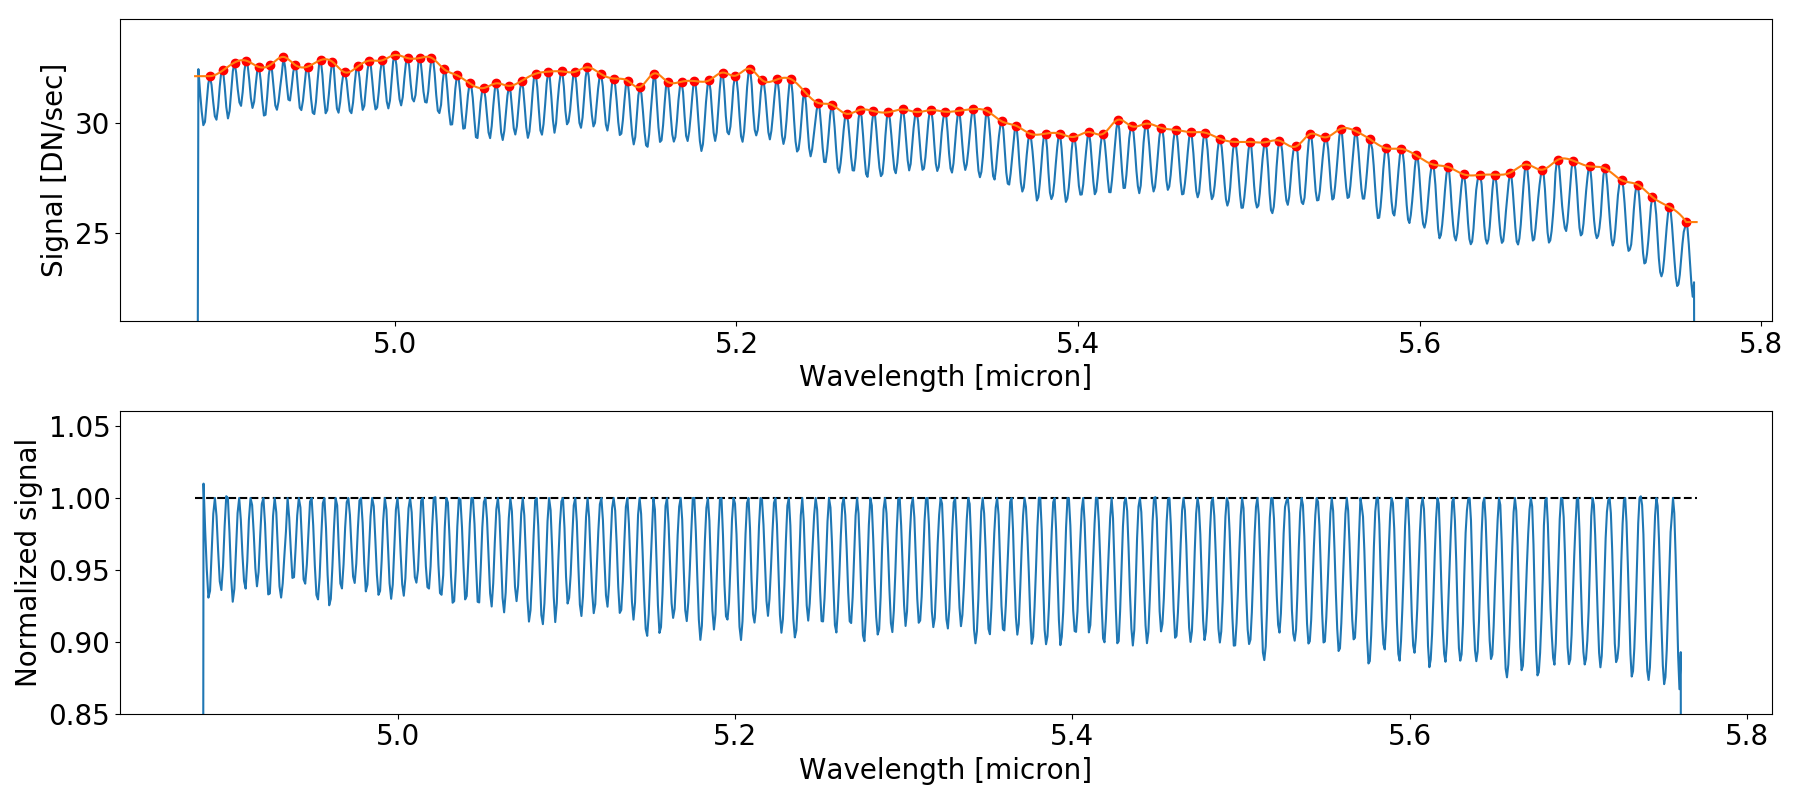

<IPython.core.display.Javascript object>


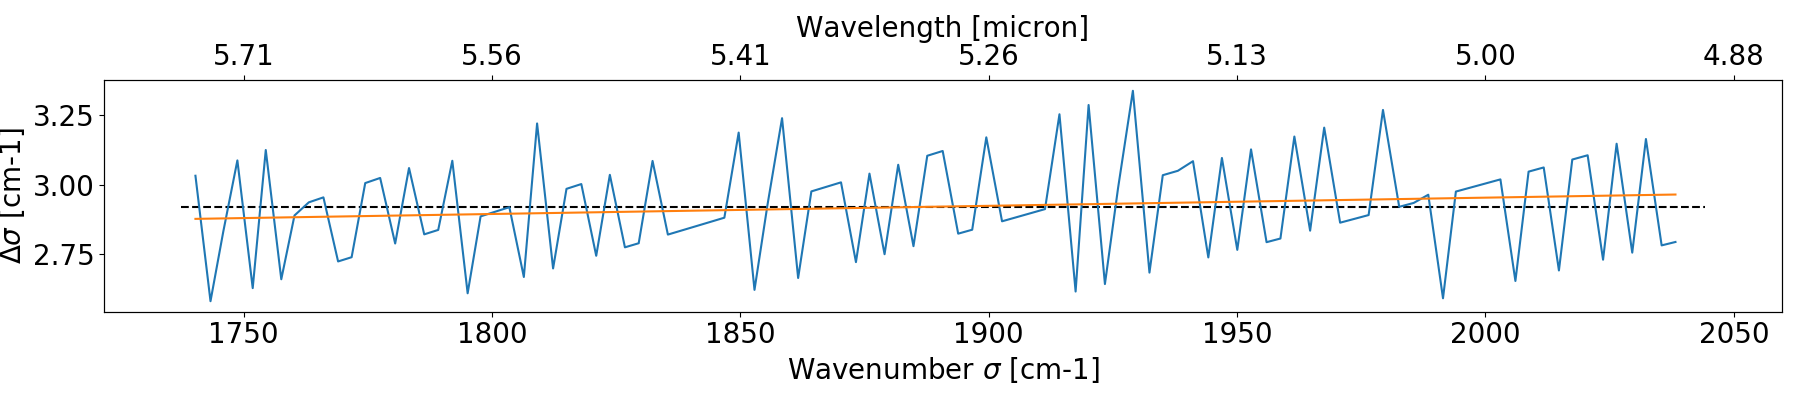

In [6]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(lambdaMap[ypos,xpos],ext_source_norm[0])
axs[0].plot(lambdaMap[ypos,xpos][ext_source_norm[1]],ext_source_norm[0][ext_source_norm[1]],'ro')
axs[0].plot(lambdaMap[ypos,xpos],ext_source_norm[2])
axs[1].plot(lambdaMap[ypos,xpos],ext_source_norm[0]/ext_source_norm[2])
axs[1].hlines(1,4.88,5.77,linestyle='dashed')
axs[0].set_ylim(21)
axs[1].set_ylim(0.85)
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlabel('Wavelength [micron]')
plt.tight_layout()

fig = plt.figure(figsize=(18,4))
axs1 = fig.add_subplot(111)
axs2 = axs1.twiny()
axs1.plot(fringepeaks_wavenumber[1:-2],np.diff(fringepeaks_wavenumber)[1:-1])
axs1.plot(fringepeaks_wavenumber[1:-2],funcs.straight_line(fringepeaks_wavenumber[1:-2],*popt))
axs1.hlines(mean_fringepeak_separation,fringepeaks_wavenumber[0],fringepeaks_wavenumber[-1],linestyle='dashed')
axs1.set_xlabel(r'Wavenumber $\sigma$ [cm-1]')
axs1.set_ylabel(r'$\Delta \sigma$ [cm-1]')
axs2.set_xlim(axs1.get_xlim())
tickmarks = np.array([1750.,1800.,1850.,1900.,1950.,2000.,2050.])
axs2.set_xticks(tickmarks)
axs2.set_xticklabels(funcs.tick_function(tickmarks))
axs2.set_xlabel('Wavelength [micron]')
plt.tight_layout()

In [7]:
sel = np.nonzero(ext_source_norm[0])
ext_wavenumbers = np.flipud(10000./lambdaMap[ypos,xpos][sel])
ext_norm_signal = np.flipud((ext_source_norm[0]/ext_source_norm[2])[sel])

# define scanning window (arbitrarily set to 2*period)
N=1
while ext_wavenumbers[N]-ext_wavenumbers[0] < 2*mean_fringepeak_separation: N+=1

# Scan fringes
ext_R,ext_D,ext_sigma_R,ext_sigma_D = [np.full(len(ext_wavenumbers),np.nan) for j in range(4)]

displacements = np.arange(-1,1,0.1) # um
len_numerics = []
for displacement in displacements:
    R0,D0 = 0.10,1/(2*mean_fringepeak_separation) + displacement/10000.
    for i in range(len(ext_wavenumbers)-N):
        wvnr_segment = ext_wavenumbers[i: N+i].copy()
        array_segment  = ext_norm_signal[i: N+i].copy()

        # least-squares fitting
        try: 
            popt,pcov = curve_fit(funcs.FPfunc_noPhaseShift,wvnr_segment,array_segment,p0=(R0,D0),absolute_sigma=True,method='lm')
            ext_D[i: N+i] = popt[1]

        except RuntimeError: 
            continue
    len_numerics.append(len(np.where(np.abs(np.diff(ext_D))*10000.>1)[0]))
len_numerics = np.array(len_numerics)

R0,D0 = 0.10,1/(2*mean_fringepeak_separation) + displacements[np.argmin(len_numerics)]/10000.
for i in range(len(ext_wavenumbers)-N):
    wvnr_segment = ext_wavenumbers[i: N+i].copy()
    array_segment  = ext_norm_signal[i: N+i].copy()

    # least-squares fitting
    try: 
        popt,pcov = curve_fit(funcs.FPfunc_noPhaseShift,wvnr_segment,array_segment,p0=(R0,D0),absolute_sigma=True,method='lm')
        TR = funcs.FPfunc_noPhaseShift(wvnr_segment,*popt)

        ext_R[i: N+i] = popt[0]
        ext_D[i: N+i] = popt[1]
        ext_sigma_R[i: N+i] = np.sqrt(np.diag(pcov))[0]
        ext_sigma_D[i: N+i] = np.sqrt(np.diag(pcov))[1]
        
    except RuntimeError: 
        continue
# take care about numerics!
if len_numerics[np.argmin(len_numerics)] != 0:
    ext_R,ext_D,numerics = funcs.cleanRD(ext_R,ext_D)

#> transmittance function
ext_TR = funcs.FPfunc_noPhaseShift(ext_wavenumbers,ext_R,ext_D)

<IPython.core.display.Javascript object>


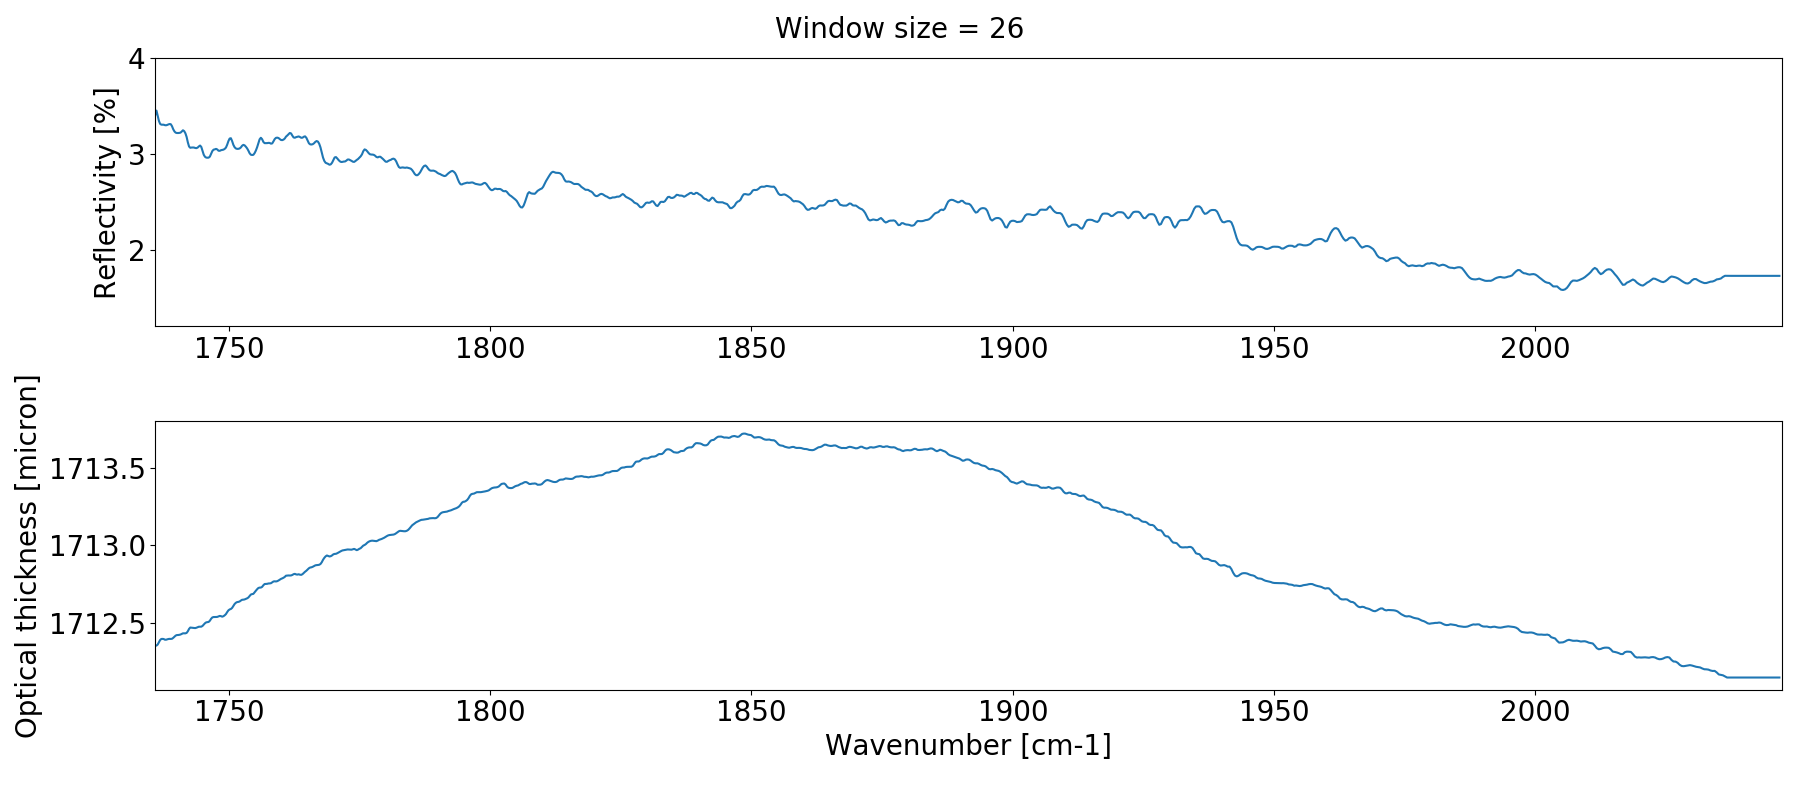

<IPython.core.display.Javascript object>


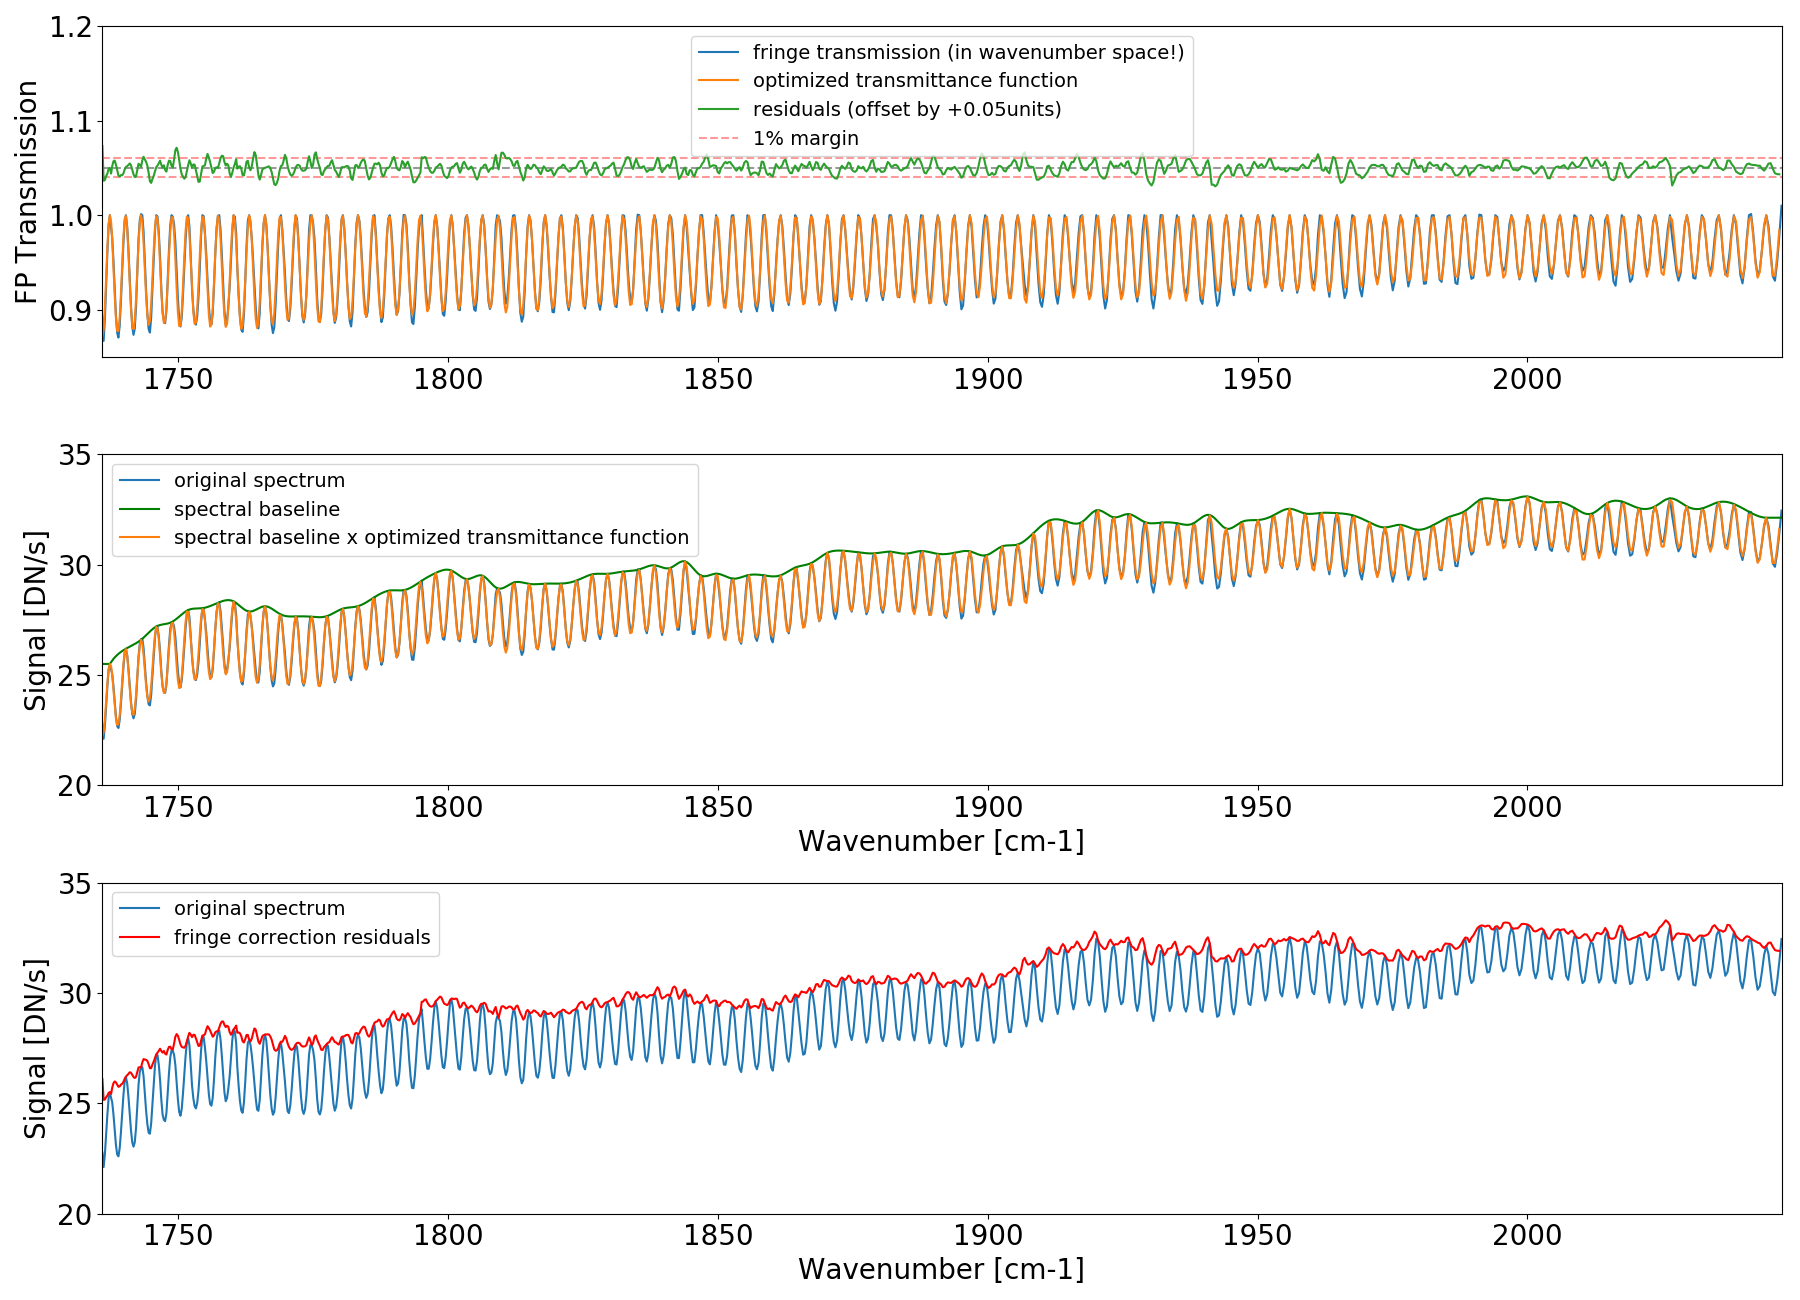

In [21]:
# let's look at the results
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(ext_wavenumbers,ext_R*100.)
axs[0].set_xlim(ext_wavenumbers[0],ext_wavenumbers[-1])
axs[0].set_ylim(1.2,4)
axs[0].set_ylabel('Reflectivity [%]')
axs[1].plot(ext_wavenumbers,ext_D*10000.)
if len_numerics[np.argmin(len_numerics)] != 0:
    axs[1].plot(ext_wavenumbers[numerics],ext_D[numerics]*10000,'ro',markersize=1,label='numerics')
axs[1].set_xlim(ext_wavenumbers[0],ext_wavenumbers[-1])
axs[1].set_ylabel('Optical thickness [micron]')
axs[1].set_xlabel('Wavenumber [cm-1]')
axs[1].legend()
plt.suptitle('Window size = {}'.format(N),fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# let's apply the optimized transmittance function as our "fringe correction"
fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].plot(ext_wavenumbers,ext_norm_signal,label='fringe transmission (in wavenumber space!)')
axs[0].plot(ext_wavenumbers,ext_TR,label='optimized transmittance function')
axs[0].hlines(1.05,ext_wavenumbers[0],ext_wavenumbers[-1],alpha=0.4,linestyle='dashed')
axs[0].plot(ext_wavenumbers,ext_norm_signal/ext_TR +0.05,label='residuals (offset by +0.05units)')
axs[0].hlines([1.04,1.06],ext_wavenumbers[0],ext_wavenumbers[-1],'r',alpha=0.4,linestyle='dashed',label='1% margin')
axs[0].set_xlim(ext_wavenumbers[0],ext_wavenumbers[-1])
axs[0].set_ylim(0.85,1.2)
axs[0].set_ylabel('FP Transmission')
axs[0].legend(loc='upper center')
axs[1].plot(ext_wavenumbers,np.flipud(ext_source_norm[0][sel]),label='original spectrum')
axs[1].plot(ext_wavenumbers,np.flipud(ext_source_norm[2][sel]),'g',label='spectral baseline')
axs[1].plot(ext_wavenumbers,np.flipud(ext_source_norm[2][sel])*ext_TR,label='spectral baseline x optimized transmittance function')
axs[1].set_ylim(20,35)
axs[1].set_xlim(ext_wavenumbers[0],ext_wavenumbers[-1])
axs[1].set_ylabel('Signal [DN/s]')
axs[2].plot(ext_wavenumbers,np.flipud(ext_source_norm[0][sel]),label='original spectrum')
axs[2].plot(ext_wavenumbers,np.flipud(ext_source_norm[0][sel])/ext_TR,'r',label='fringe correction residuals')
axs[2].set_xlim(ext_wavenumbers[0],ext_wavenumbers[-1])
axs[2].set_ylim(20,35)
axs[2].set_ylabel('Signal [DN/s]')
for plot in range(1,3): 
    axs[plot].set_xlabel('Wavenumber [cm-1]')
    axs[plot].legend(loc='upper left')
plt.tight_layout()

### Remarks:
* By "scanning" the fringe transmission and fitting a Fabry-Pérot transmittance function in each scan window, it is possible to probe the local optical properties of the MIRI SW detector.
* Much like in Notebook 7 - Test 1, we find an intensity reflectivity R of the order of two to three percent. Note that here we speak of an **effective** reflectivity. Namely an averaged quantity born from the reflectivity of the different detector layers, that yield the fringe amplitudes we see.
* For the optical thickness determination, we see a smooth curve over the wavenumber range. The "wavenumber range" in fact corresponds to a physical location on the detector (where light of a given wavelength is incident onto a given pixel). The variation of the optical thickness over the detector is of the order of 1.5um. Such a variation is very small indeed. Interestingly enough a private communication with Dr. Mike Ressler sheds light for a possible cause for the kind of variation seen:  
  
    From Dr. Mike Ressler: "*The biggest "non-flatness" term will be the warping of the chip due to how the detector is attached to the motherboard. This will be far larger than any other term from the actual wafer manufacturing process or the detector growth process. The detector surface typically looks like a potato chip (crisp, if you are in Britain), so you can expect 10-15 microns peak-to-peak variation of the surface (typically center is high, two opposing corners are low, the other two corners are in the middle).*"
  
    Given the above excerpt, it could be that the optical thickness variation measured probes the "warping of the chip" (center is high, sides are low). We show the value of the optical thickness as a function of detector pixel position below.

<IPython.core.display.Javascript object>


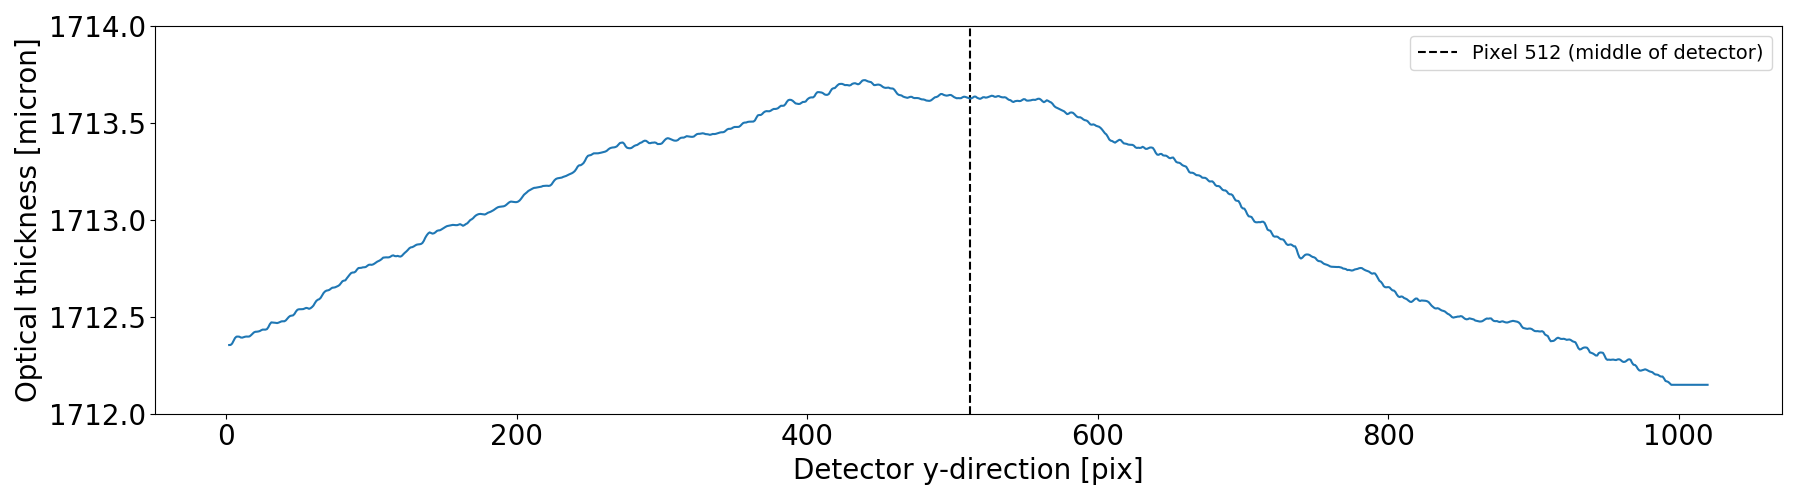

In [11]:
plt.figure(figsize=(18,5))
plt.plot(np.arange(1024)[sel],ext_D*10000)
plt.vlines(512,1712,1714,linestyle='dashed',label='Pixel 512 (middle of detector)')
plt.ylim(1712,1714)
plt.ylabel('Optical thickness [micron]')
plt.xlabel('Detector y-direction [pix]')
plt.legend()
plt.tight_layout()

### Test 1: What information can we extract from the fringe residuals?
In Notebook 2 - Test 3 we first attempted to study the beating of the etalon frequency and the detector-produced fringe frequency. Within that broader context, we see now in the fringe transmission of the extended source (no etalon) a beating of a similar nature. We have removed/corrected the high-frequency fringe from the data (to the best of our ability). In the residuals of this process however a second frequency can still be seen. By estimating the apparent optical properties of this second fringe (as we've done many times before), insight into the origin of the fringe can be gained. So let's look at the residuals by first smoothing the data.

In [12]:
residuals = np.flipud(ext_source_norm[0][sel])/ext_TR # array in 
# apply low-pass filter
window_length = 51
polyorder = 3

no_nan = ~np.isnan(np.flipud(ext_source_norm[0][sel])/ext_TR)

smoothed_residuals = np.zeros(len(ext_wavenumbers))
smoothed_residuals[no_nan] = savgol_filter(residuals[no_nan],window_length,polyorder)
smoothed_residuals[:window_length]  = medfilt(residuals[no_nan],window_length)[:window_length]
smoothed_residuals[-window_length:] = medfilt(residuals[no_nan],window_length)[-window_length:]

# peaks in smoothed residuals
npixels = 1024; npeaks = 7
peaks = funcs.find_peaks(smoothed_residuals,min_dist=npixels/npeaks/2)

<IPython.core.display.Javascript object>


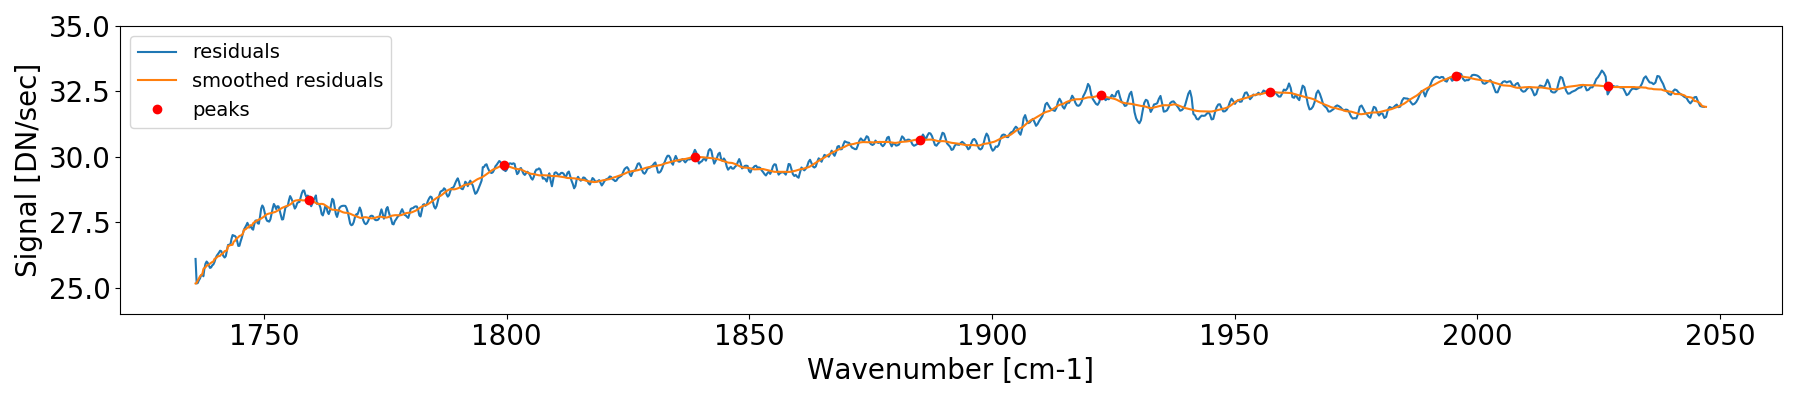

In [13]:
plt.figure(figsize=(18,4))
plt.plot(ext_wavenumbers,residuals,label='residuals')
plt.plot(ext_wavenumbers,smoothed_residuals,label='smoothed residuals')
plt.plot(ext_wavenumbers[peaks],smoothed_residuals[peaks],'ro',label='peaks')
plt.ylim(24,35)
plt.xlabel('Wavenumber [cm-1]')
plt.ylabel('Signal [DN/sec]')
plt.legend()
plt.tight_layout()

In [14]:
# compute minima separation (to determine optical thickness of beating component)
beatingminima_wavenumber      = ext_wavenumbers[peaks]            # cm-1
mean_beatingminima_separation = np.mean(np.diff(beatingminima_wavenumber))
# fit straight line through distance data for comparison
popt,pcov = curve_fit(funcs.straight_line,beatingminima_wavenumber[:-1],np.diff(beatingminima_wavenumber))

print r'Mean etalon line separation in wavenumber space is: Δσ = {} cm-1'.format(round(mean_beatingminima_separation,2) )
print r'The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = {} um'.format(round(10000./(2*mean_beatingminima_separation),2) )
print r'The beating fringe is produced by an etalon with an optical thickness: D = {}-{} um = {} um'.format(round(10000./(2*mean_fringepeak_separation),2),round(10000./(2*mean_beatingminima_separation),2),round(-10000./(2*mean_beatingminima_separation) + 10000./(2*mean_fringepeak_separation),2) )

Mean etalon line separation in wavenumber space is: Δσ = 38.22 cm-1
The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = 130.82 um
The beating fringe is produced by an etalon with an optical thickness: D = 1712.34-130.82 um = 1581.52 um


<IPython.core.display.Javascript object>


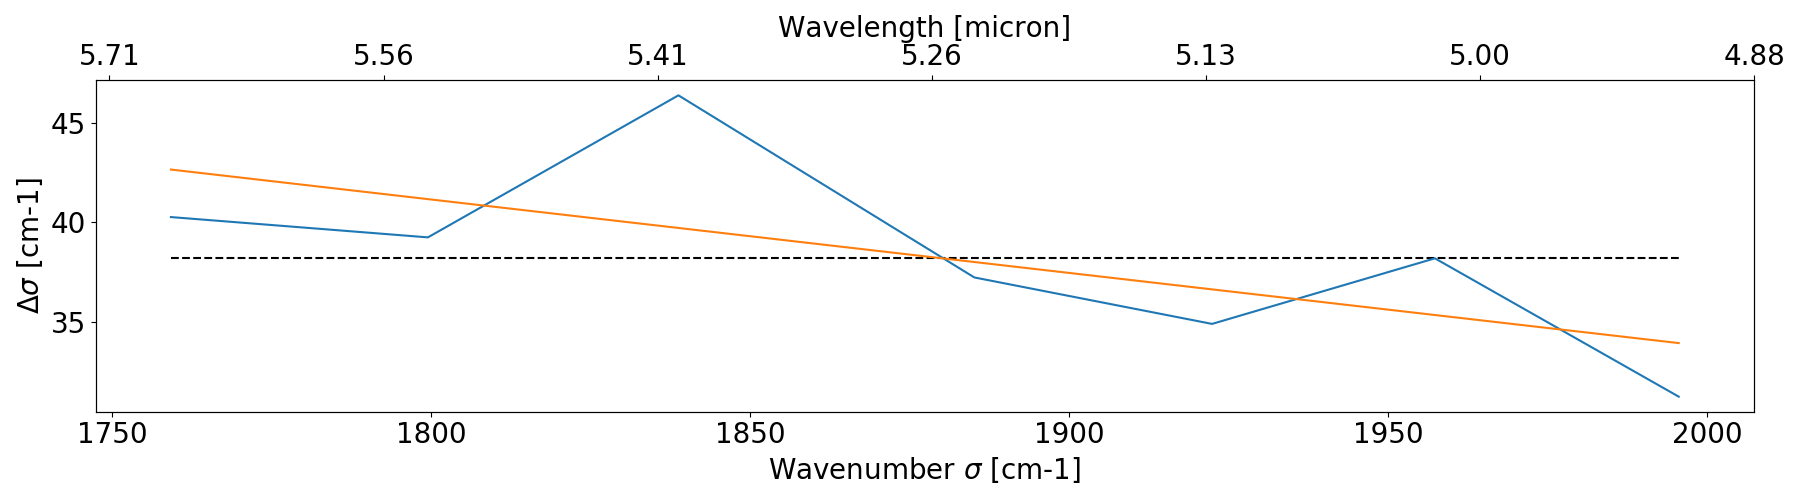

In [15]:
fig = plt.figure(figsize=(18,5))
axs1 = fig.add_subplot(111)
axs2 = axs1.twiny()
axs1.plot(beatingminima_wavenumber[:-1],np.diff(beatingminima_wavenumber))
axs1.plot(beatingminima_wavenumber[:-1],funcs.straight_line(beatingminima_wavenumber[:-1],*popt))
axs1.hlines(mean_beatingminima_separation,beatingminima_wavenumber[0],beatingminima_wavenumber[-2],linestyle='dashed')
axs1.set_xlabel(r'Wavenumber $\sigma$ [cm-1]')
axs1.set_ylabel(r'$\Delta \sigma$ [cm-1]')
axs2.set_xlim(axs1.get_xlim())
tickmarks = np.array([1750.,1800.,1850.,1900.,1950.,2000.,2050.])
axs2.set_xticks(tickmarks)
axs2.set_xticklabels(funcs.tick_function(tickmarks))
axs2.set_xlabel('Wavelength [micron]')
plt.tight_layout()

### Remarks:
* The determination of the peaks in the residuals is not accurate, however it does provide a zeroth order approximation of the optical thickness of the beating component.
* Given the supposition that the high-frequency fringe is produced by an etalon made up of the anti-reflection coating on one side, and the pixel metallization on the other, the optical thickness attributed to this etalon is the largest optical thickness the detector has to offer. As such the optical thickness of the beating frequency can only be smaller. We find that the beating resonator has an optical thickness of ~1580um.
* So we know that the full detector has an optical thickness of ~1710um, and that a layer within the detector has an optical thickness of 1580um. Interestingly enough, dividing 1580um by a refractive index of 3.39 for silicon (primary material of all MIRI detector optical layers) yields a geometric thickness of ~465um. We know this to be the geometric thickness of the silicon substrate of the MIRI SW detector. To complement this fact, dividing the 130um optical thickness determined from the beating peak separation by 3.39 yields a geometric thickness of 38um. We know that the geometric thickness of the MIRI active layer has a thickness of 25-35um (MIRI PASP paper VII), and that this layer is followed by a blocking layer of pure silicon 3-4um thick. As such the 130um optical thickness is attributed to an interplay of the latter two elements.
* If the MIRI substrate, the active layer, and the blocking layer are made out of silicon, there should be no effective "interface" between the three layers to produce another fringe, so what gives? 
  
    From George Rieke: "*A little-known fact about our arrays is that the buried contact (electrode placed between silicon subtrate and active layer) is quite reflective. Therefore, one possibility is interference in the substrate before the photons enter the IR active layer - that is they come in through the substrate and there is a FP cavity about 400-500um thick consisting of a reflection at the buried contact and another reflection at the entrance side of the substrate.*"
  
  Based on the message by George Rieke, we thus construct a better image of the resonator that is the MIRI detector. The fringes seen in MRS data are caused by the beating between:
  * the anti-reflection coating and the buried contact (optical thickness ~1580um).
  * the buried contact and the pixel metallization (optical thickness ~130um).
  * the anti-reflection coating and the pixel metallization (optical thickness ~1710um).
  Important to mention here that these can be considered as independent etalons in their own right, however each reflecting surface of each etalon has a **different chemical constituent**.
  
What is the intensity reflectivity of the beating frequency?

In [16]:
# Take univariate spline through the fitted peaks
interpolator = InterpolatedUnivariateSpline(ext_wavenumbers[peaks],smoothed_residuals[peaks],k=1,ext=0)
peakprofile = interpolator(ext_wavenumbers)

# approximate reflectivity
T_e = 0.965
F,R_solution1,R_solution2 = funcs.reflectivity_from_continuum(T_e)
print ' Finesse = {} \n R_solution1 = {} \n R_solution2 = {} (physically valid solution)\n'.format(F,round(R_solution1,2),round(R_solution2,3) )
R_mean = R_solution2

# transmittance function from rough parameter estimates
D_mean   = 1./(2*mean_beatingminima_separation)    # cm
phi = np.pi+0.8                                        # rad

T_e = funcs.FPfunc(ext_wavenumbers,R_mean,D_mean,phi)  # [-]

 Finesse = 0.0362694300518 
 R_solution1 = 112.28 
 R_solution2 = 0.009 (physically valid solution)



<IPython.core.display.Javascript object>


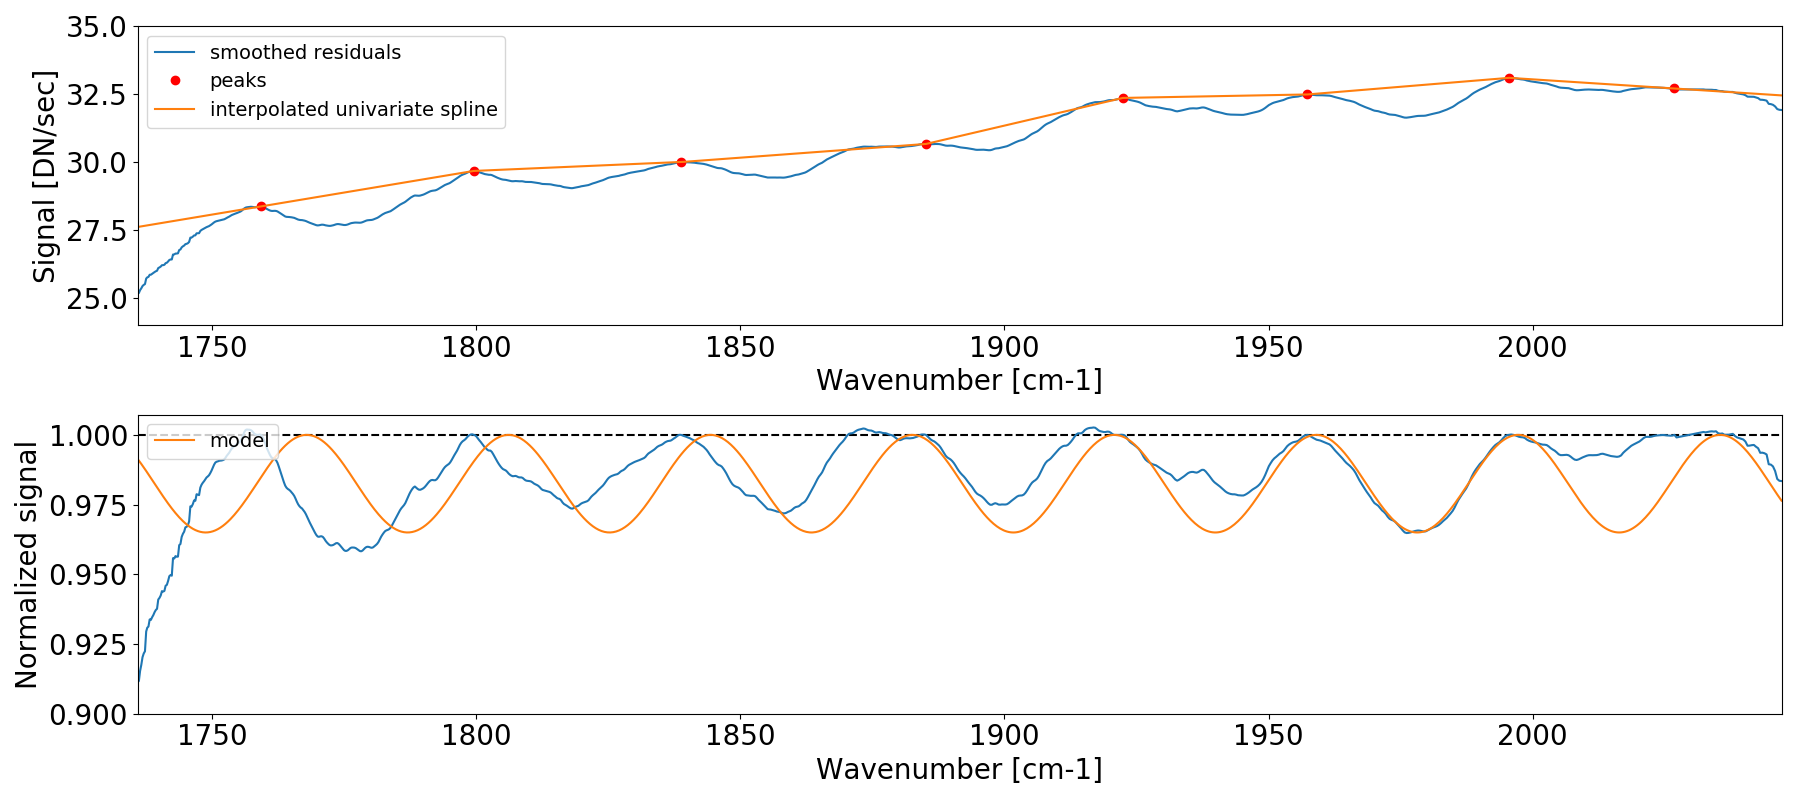

In [17]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(ext_wavenumbers,smoothed_residuals,label='smoothed residuals')
axs[0].plot(ext_wavenumbers[peaks],smoothed_residuals[peaks],'ro',label='peaks')
axs[0].plot(ext_wavenumbers,peakprofile,label='interpolated univariate spline')
axs[0].set_ylim(24,35)
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].plot(ext_wavenumbers,smoothed_residuals/peakprofile)
axs[1].plot(ext_wavenumbers,T_e,label='model')
axs[1].hlines(1,ext_wavenumbers[0],ext_wavenumbers[-1],linestyle='dashed')
axs[1].set_ylim(0.9)
axs[1].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlim(ext_wavenumbers[0],ext_wavenumbers[-1])
    axs[plot].set_xlabel('Wavenumber [cm-1]')
    axs[plot].legend(loc='upper left')
plt.tight_layout()

### Remarks:
* The distance between the fringe peaks is not constant, thus the fringe transmission profile cannot be matched with a single frequency / optical thickness. It is difficult to quantify however the verity of this statement given the rough estimation of the fringe peaks.
* The reflectivity of the beating fringe (**in the extended source data**) is estimated to be ~0.9%. Below we show the transmission profile of the buried contact. Note that, assuming that the contact does not absorb, the transmission T is equal to 1-R, where R stands for the intensity reflectivity.
* From the figure below we see that at 5um the reflectivity of the buried contact is ~0.36%; that is less than half the reflectivity that we computed. However for an asymmetric cavity (etalon with two different reflecting surfaces) the effective reflectivity is equal to the square root of the product of the individual reflectivities (i.e. $R_{eff} = \sqrt{R_{1}\cdot R_{2}}$). Taking $R_{eff}=0.009$ and $R_{1}=0.0036$ yields $R_{2}=R_{eff}^2 /R_{1} = 0.0225 = 2.25\%$. 
* The reflectivity of aluminium (for the pixel metallization layer) is in general close to 100% (~98% at 5um). This yields an effective reflectivity for the buried-contact + pixels-metallization etalon $R_{eff} = \sqrt{R_{1}\cdot R_{2}} = \sqrt{0.0036\cdot 0.98} = 6\%$. The cavity we are referring to here is the detector active layer + blocking layer.
* Keep in mind that, due to the absorptive nature of the MIRI detector active layer, light that would normally be interfering is removed from the system (impurity concentration in silicon converts incoming photons into electron-hole pairs). This "removal" is quantified by the extinction or absorption coefficient of the infrared active layer and dampens the fringe amplitude. The result is a decrease in the apparent reflectivity of the system. This of course would apply the same for a fringe between the anti-reflection coating and the pixel metallization, as well as a fringe between the buried contact and the pixel metallization.
* The reflectivity of the anti-reflection coating is provided as a measure of *reflectance* by the manufacturer. The distinction between reflectivity and reflectance is that the former applies to homogeneous and semi-infinite materials, while the latter apples to layered, finite media (i.e. the two quantities are **not** equivalent). The reflectance of the MIRI SW detector anti-reflection coating at 5um is 7.7% (see reflectance plot below). Using this value for $R_{2}$ yields $R_{eff} = \sqrt{0.0036\cdot 0.077} = 1.7\%$. Though this result is somewhat uncertain, it is close enough to the measured $R_{eff}$ of 0.9%. However it does mean that from the optical properties mentioned here, we would expect a larger amplitude for the beating fringe than what is seen in the extended source data. How would the conclusion change if we were to look at the fringes in a point source observation, or in an internal calibration source observation?

In [18]:
wav_data_trans,transmission = funcs.buriedelectrode_transmission(workDir=workDir)
wav_data_refl,reflectance = funcs.SW_ARcoat_reflectance(workDir=workDir)

<IPython.core.display.Javascript object>


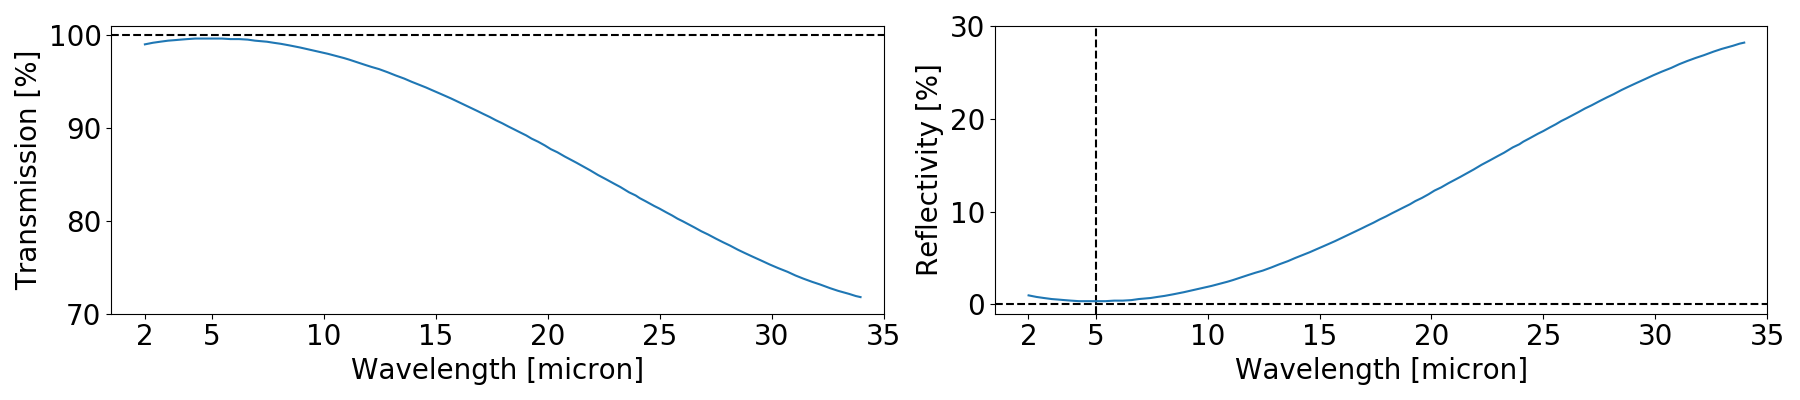

<IPython.core.display.Javascript object>


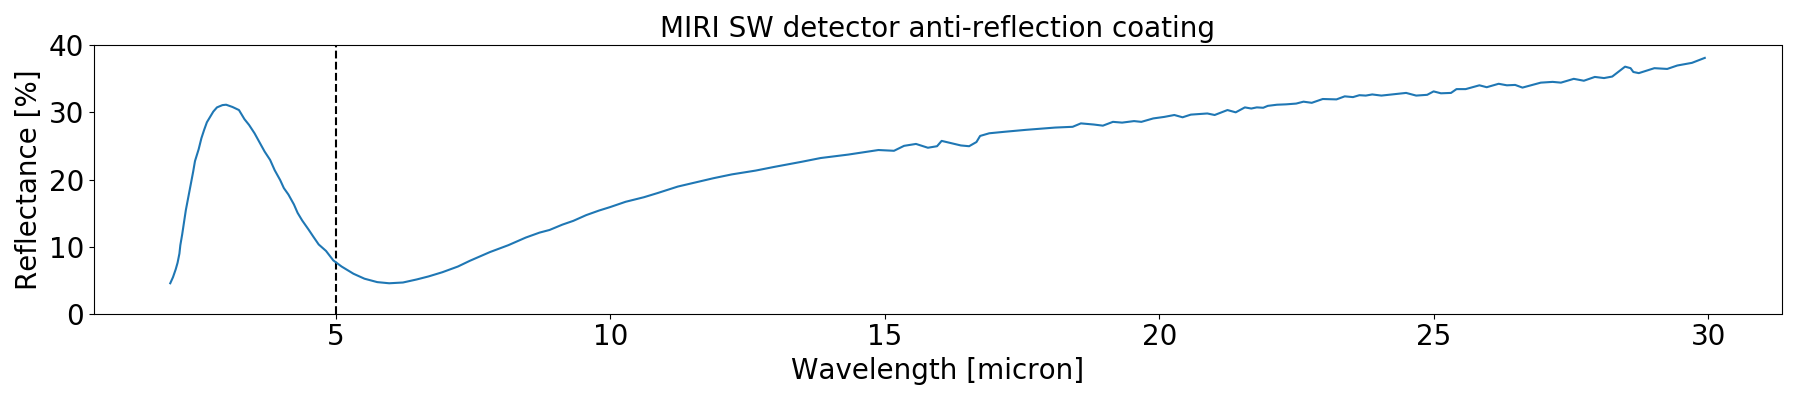

In [19]:
# Buried contact
fig,axs = plt.subplots(1,2,figsize=(18,4))
axs[0].plot(wav_data_trans,transmission*100.)
axs[1].plot(wav_data_trans,(1-transmission)*100. )
axs[1].vlines(5,-1,30,linestyle='dashed')
axs[0].set_ylim(70,101)
axs[1].set_ylim(-1,30)
for plot in range(2): 
    axs[plot].set_xticks([2,5,10,15,20,25,30,35])
    axs[plot].hlines([0,100],0.5,35,linestyle='dashed')
    axs[plot].set_xlim(0.5,35)
    axs[plot].set_xlabel('Wavelength [micron]')
axs[0].set_ylabel('Transmission [%]')
axs[1].set_ylabel('Reflectivity [%]')
plt.tight_layout()

# SW detector anti-reflection coating
plt.figure(figsize=(18,4))
plt.title('MIRI SW detector anti-reflection coating')
plt.plot(wav_data_refl,reflectance*100.)
plt.vlines(5,0,40,linestyle='dashed')
plt.ylim(0,40)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Reflectance [%]')
plt.tight_layout()

### Test 2: What results do we get for the optical properties of the detector when scanning the fringes seen in a point source observation?

In [ ]:
# Construct the spectral grid
lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)
# Determine point source centroid
point_source_p1_centroid = funcs.point_source_centroiding(point_source_p1_oddevencorr,band,d2cMaps,spec_grid=[lambcens,lambfwhms],fit='1D')
# Normalize the source signal
point_source_p1_norm = funcs.norm_fringe(point_source_p1_centroid[0],thres=0,min_dist=2,k=3,ext=3)

In [22]:
# Compute zeroth order optical thickness of detector from fringe peak separation
fringepeaks_wavelength     = lambcens[point_source_p1_norm[1]]              # microns
fringepeaks_wavenumber     = np.flipud(10000./fringepeaks_wavelength)       # cm-1
mean_fringepeak_separation = np.mean(np.diff(fringepeaks_wavenumber)[1:-1]) # omit first and last data point
# fit straight line through distance data for comparison
point_popt,point_pcov = curve_fit(funcs.straight_line,fringepeaks_wavenumber[1:-2],np.diff(fringepeaks_wavenumber)[1:-1])

print r'Mean etalon line separation in wavenumber space is: Δσ = {} cm-1'.format(round(mean_fringepeak_separation,2) )
print r'The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = {} um'.format(round(10000./(2*mean_fringepeak_separation),2) )

Mean etalon line separation in wavenumber space is: Δσ = 2.92 cm-1
The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = 1714.26 um


In [23]:
sel = np.nonzero(point_source_p1_norm[0])
point_wavenumbers = np.flipud(10000./lambcens[sel])
point_norm_signal = np.flipud((point_source_p1_norm[0]/point_source_p1_norm[2])[sel])

# define scanning window (arbitrarily set to 2*period)
N=1
while point_wavenumbers[N]-point_wavenumbers[0] < 2*mean_fringepeak_separation: N+=1

# Scan fringes
point_R,point_D,point_sigma_R,point_sigma_D = [np.full(len(point_wavenumbers),np.nan) for j in range(4)]

displacements = np.arange(-1,1,0.1) # um
len_numerics = []
for displacement in displacements:
    R0,D0 = 0.10,1/(2*mean_fringepeak_separation) + displacement/10000.
    for i in range(len(point_wavenumbers)-N):
        wvnr_segment = point_wavenumbers[i: N+i].copy()
        array_segment  = point_norm_signal[i: N+i].copy()

        # least-squares fitting
        try: 
            popt,pcov = curve_fit(funcs.FPfunc_noPhaseShift,wvnr_segment,array_segment,p0=(R0,D0),absolute_sigma=True,method='lm')
            point_D[i: N+i] = popt[1]

        except RuntimeError: 
            continue
    len_numerics.append(len(np.where(np.abs(np.diff(point_D))*10000.>1)[0]))
len_numerics = np.array(len_numerics)

R0,D0 = 0.10,1/(2*mean_fringepeak_separation) + displacements[np.argmin(len_numerics)]/10000.
for i in range(len(point_wavenumbers)-N):
    wvnr_segment = point_wavenumbers[i: N+i].copy()
    array_segment  = point_norm_signal[i: N+i].copy()

    # least-squares fitting
    try: 
        popt,pcov = curve_fit(funcs.FPfunc_noPhaseShift,wvnr_segment,array_segment,p0=(R0,D0),absolute_sigma=True,method='lm')
        TR = funcs.FPfunc_noPhaseShift(wvnr_segment,*popt)

        point_R[i: N+i] = popt[0]
        point_D[i: N+i] = popt[1]
        point_sigma_R[i: N+i] = np.sqrt(np.diag(pcov))[0]
        point_sigma_D[i: N+i] = np.sqrt(np.diag(pcov))[1]
        
    except RuntimeError: 
        continue
# take care about numerics!
if len_numerics[np.argmin(len_numerics)] != 0:
    point_R,point_D,numerics = funcs.cleanRD(point_R,point_D)

#> transmittance function
point_TR = funcs.FPfunc_noPhaseShift(point_wavenumbers,point_R,point_D)

In [24]:
residuals = np.flipud(point_source_p1_norm[0][sel])/point_TR # array in 
# apply low-pass filter
window_length = 21
polyorder = 3

no_nan = ~np.isnan(np.flipud(point_source_p1_norm[0][sel])/point_TR)

smoothed_residuals = np.zeros(len(point_wavenumbers))
smoothed_residuals[no_nan] = savgol_filter(residuals[no_nan],window_length,polyorder)
smoothed_residuals[:window_length]  = medfilt(residuals[no_nan],window_length)[:window_length]
smoothed_residuals[-window_length:] = medfilt(residuals[no_nan],window_length)[-window_length:]

# peaks in smoothed residuals
npixels = len(point_wavenumbers); npeaks = 7
peaks = funcs.find_peaks(smoothed_residuals,min_dist=npixels/npeaks/2)

# Take univariate spline through the fitted peaks
interpolator = InterpolatedUnivariateSpline(point_wavenumbers[peaks],smoothed_residuals[peaks],k=1,ext=0)
peakprofile = interpolator(point_wavenumbers)

# approximate reflectivity
T_e = 0.939
F,R_solution1,R_solution2 = funcs.reflectivity_from_continuum(T_e)
print ' Finesse = {} \n R_solution1 = {} \n R_solution2 = {} (physically valid solution)\n'.format(F,round(R_solution1,2),round(R_solution2,3) )
R_mean = R_solution2

# transmittance function from rough parameter estimates
D_mean   = 1./(2*mean_beatingminima_separation)    # cm
phi = np.pi+0.8                                    # rad

T_e = funcs.FPfunc(point_wavenumbers,R_mean,D_mean,phi)  # [-]

 Finesse = 0.0649627263046 
 R_solution1 = 63.56 
 R_solution2 = 0.016 (physically valid solution)



<IPython.core.display.Javascript object>


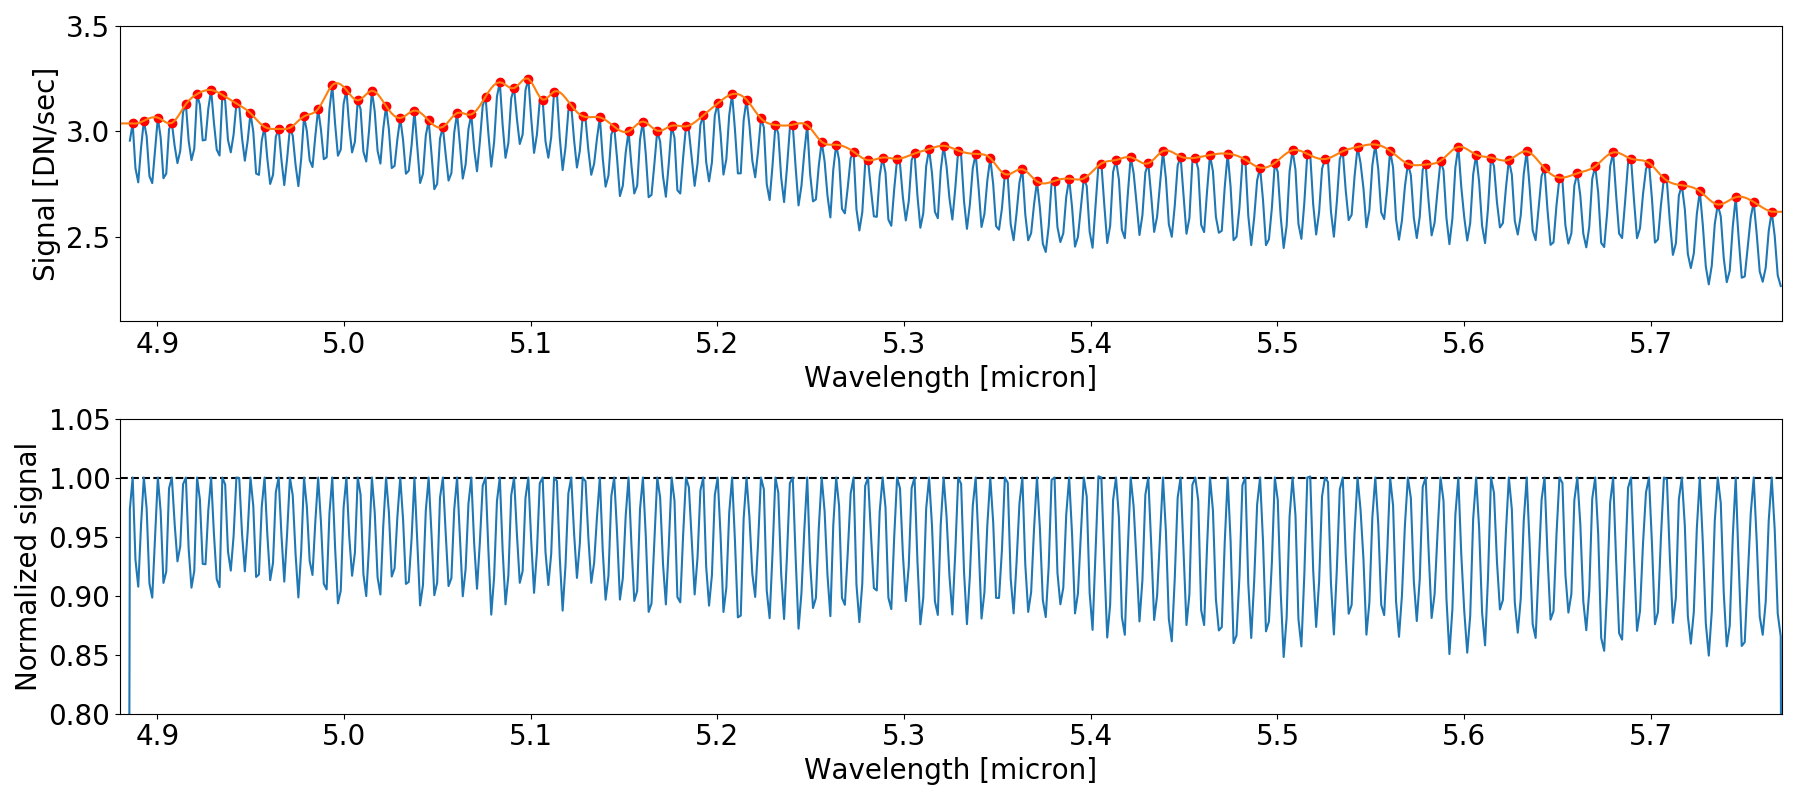

<IPython.core.display.Javascript object>


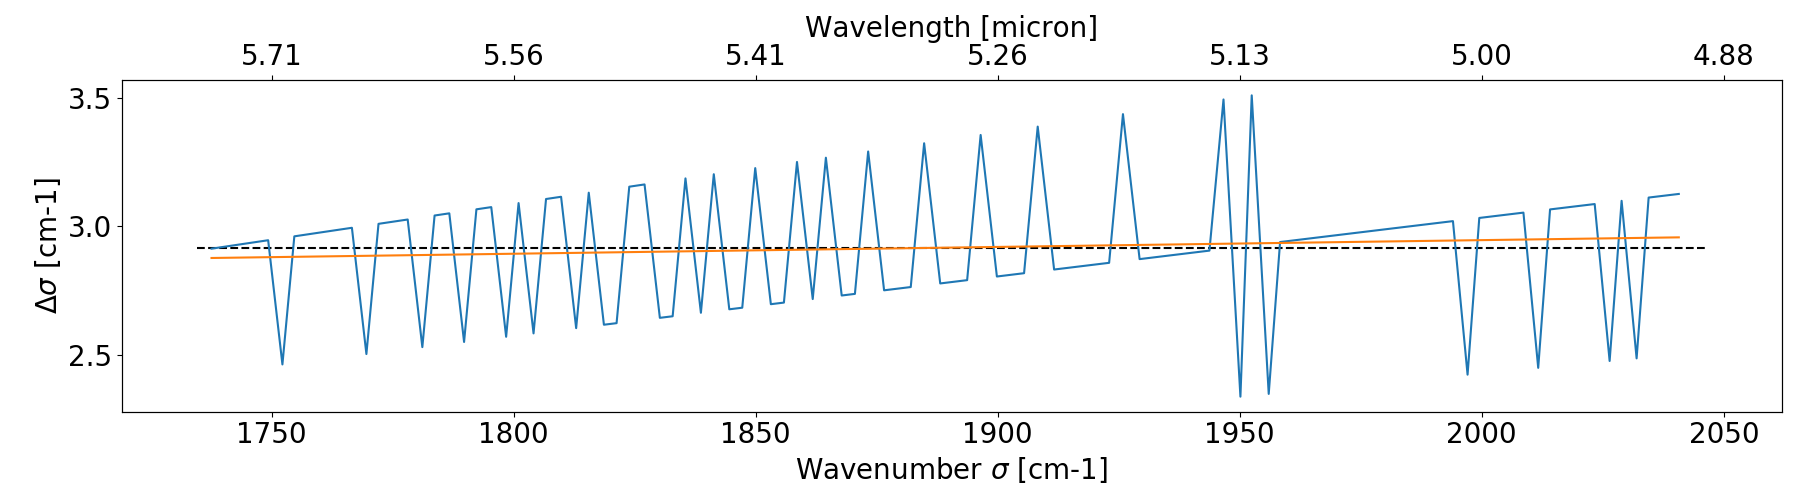

<IPython.core.display.Javascript object>


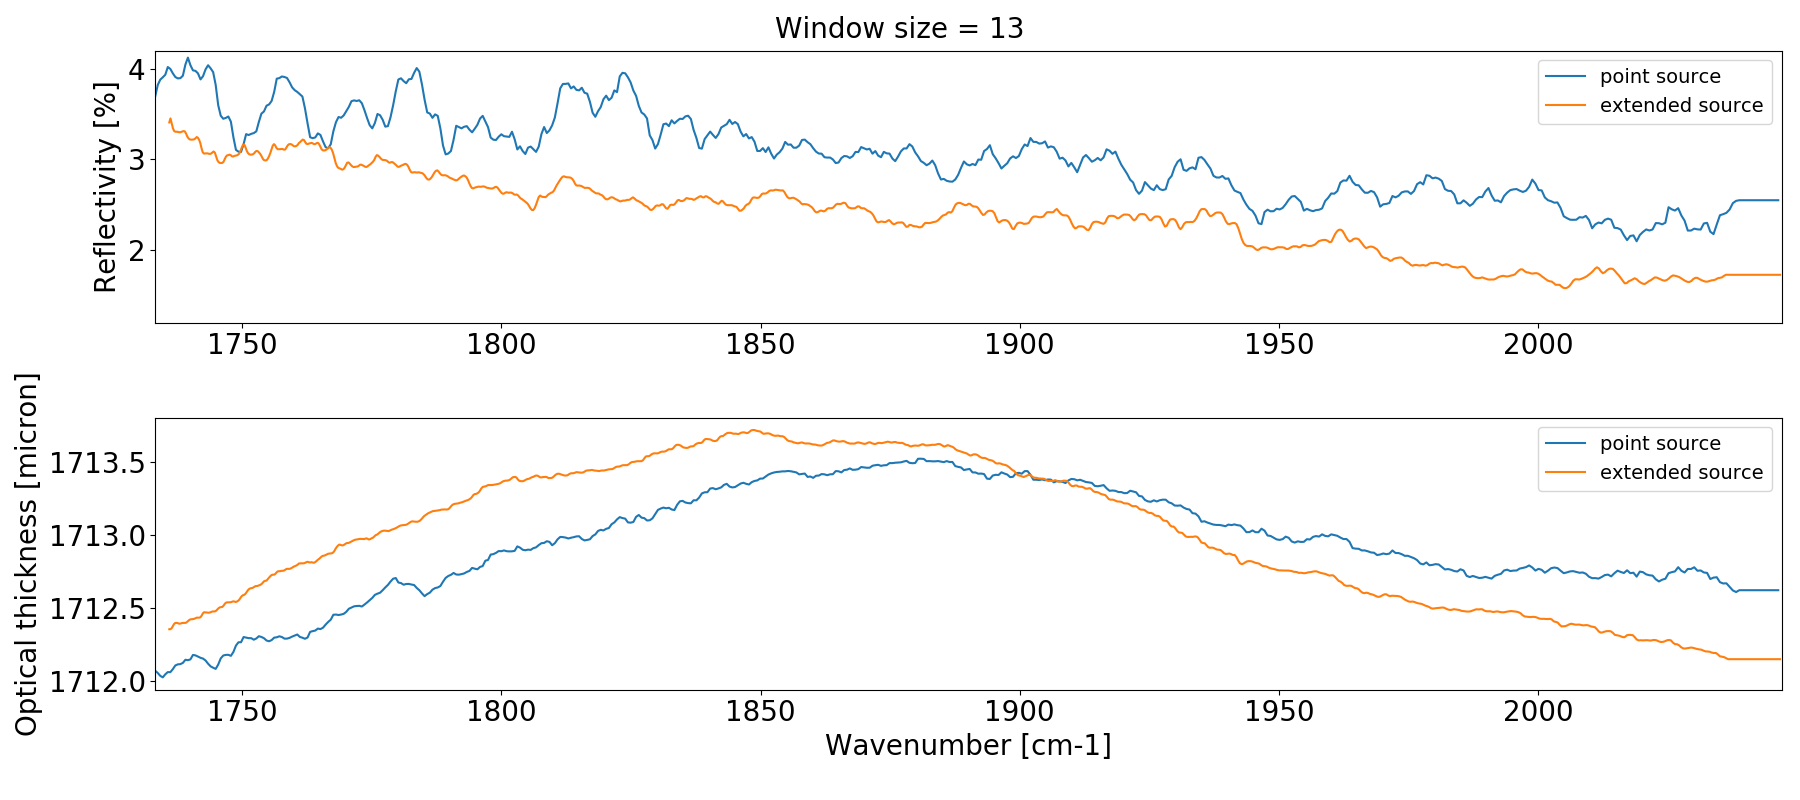

<IPython.core.display.Javascript object>


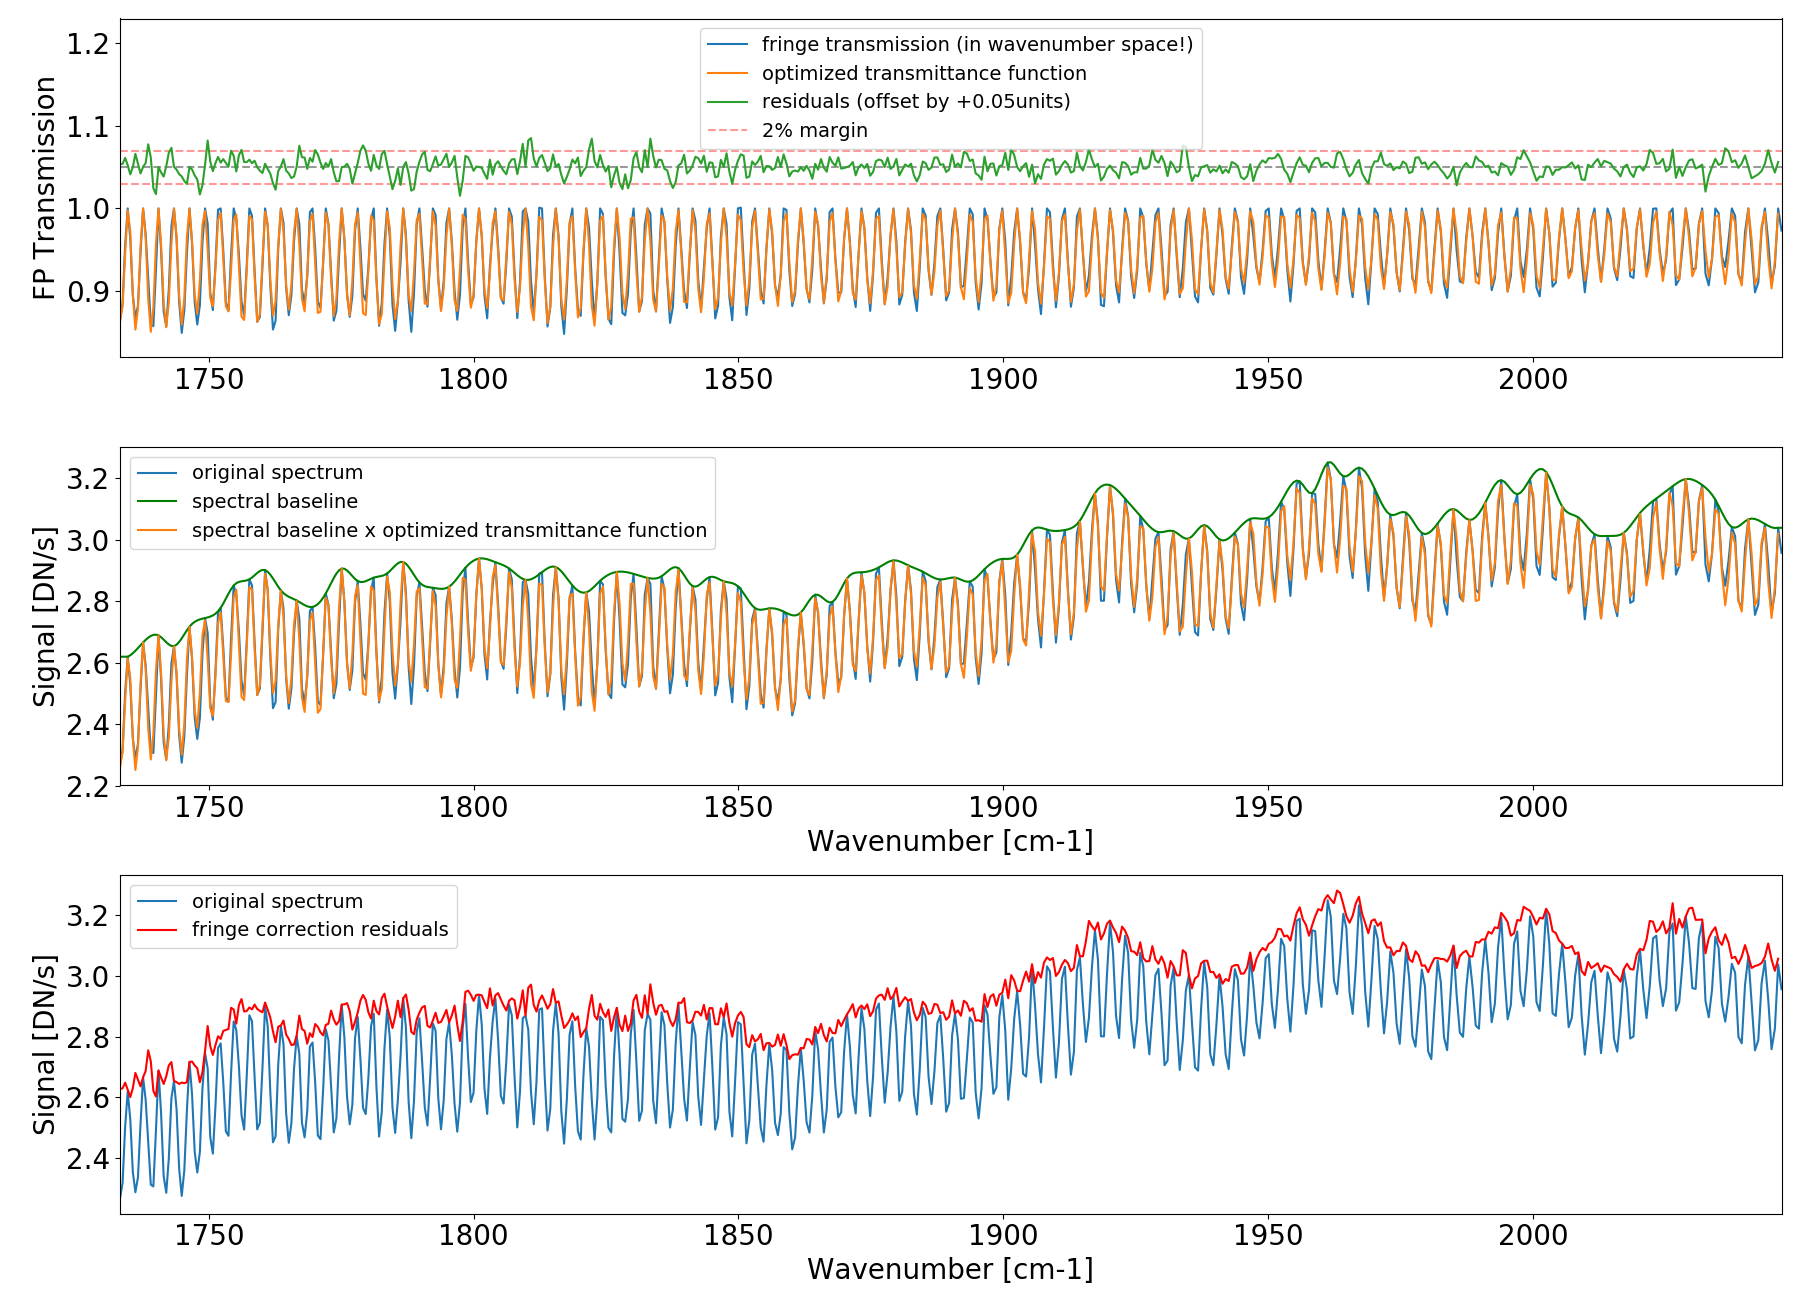

<IPython.core.display.Javascript object>


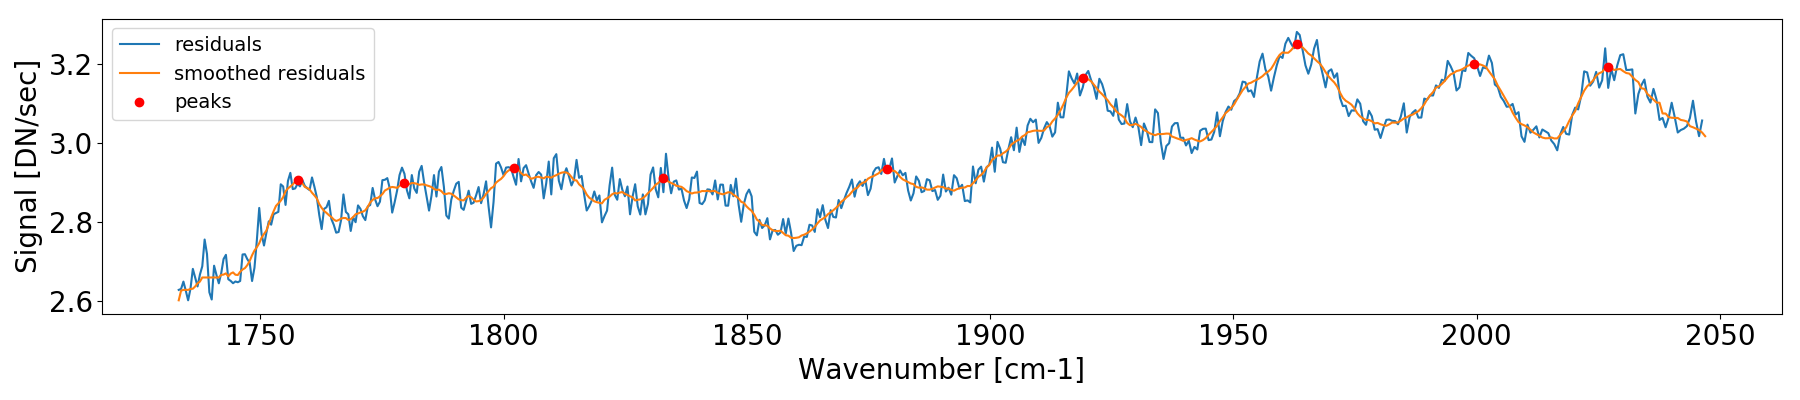

<IPython.core.display.Javascript object>


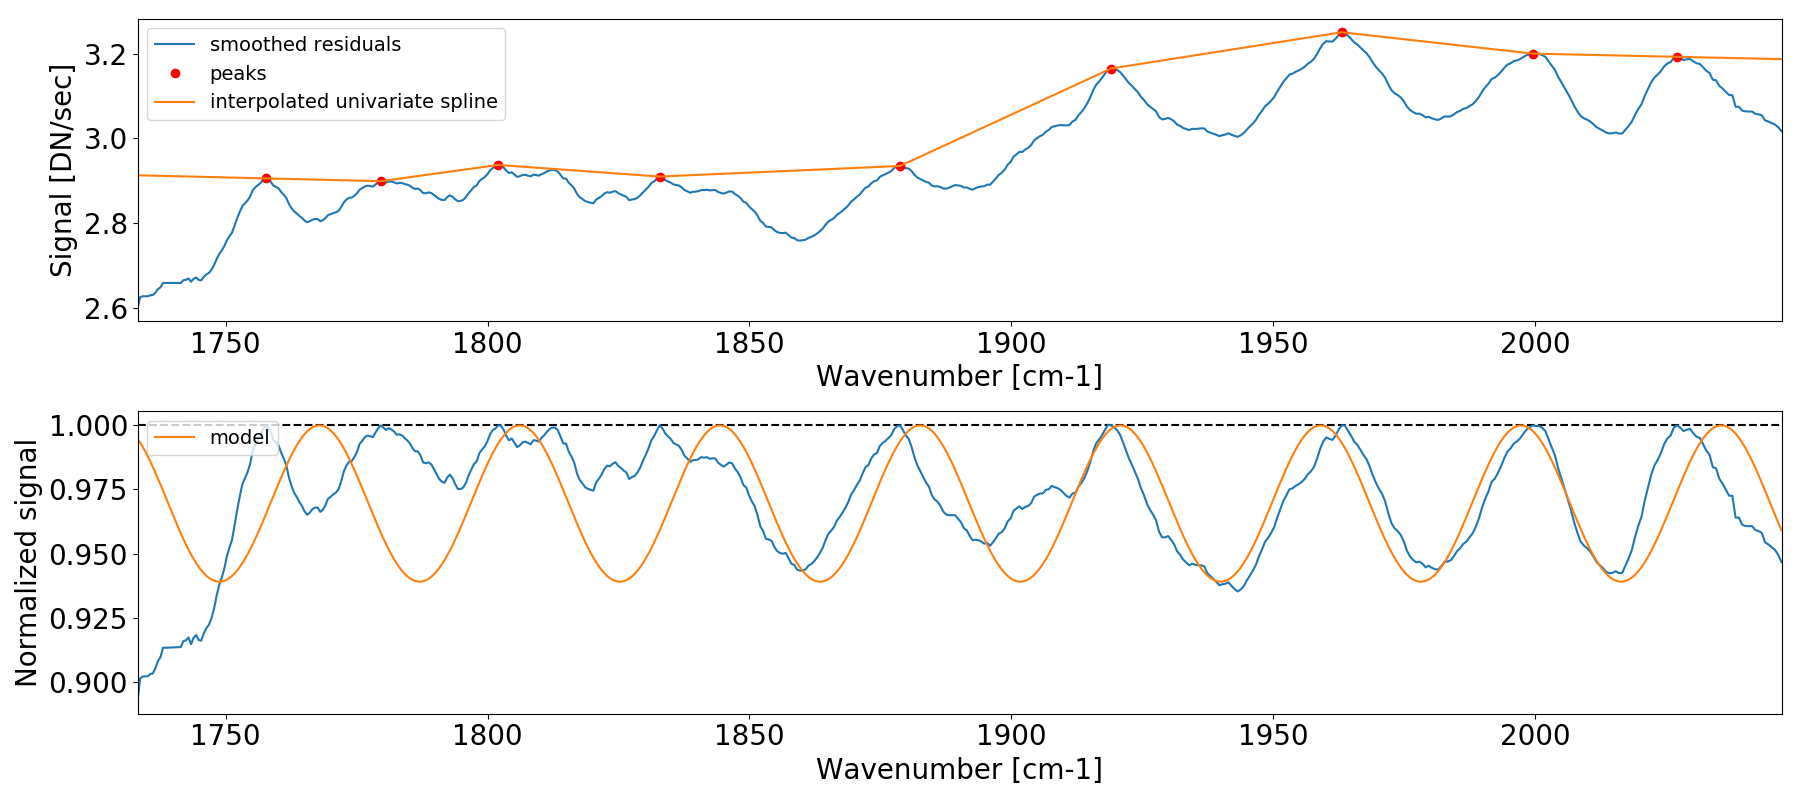

In [25]:
# let's look at the results
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(lambcens,point_source_p1_centroid[0])
axs[0].plot(lambcens[point_source_p1_norm[1]],point_source_p1_centroid[0][point_source_p1_norm[1]],'ro')
axs[0].plot(lambcens,point_source_p1_norm[2])
axs[1].plot(lambcens,point_source_p1_norm[0]/point_source_p1_norm[2])
axs[1].hlines(1,4.88,5.77,linestyle='dashed')
axs[0].set_ylim(2.1,3.5)
axs[1].set_ylim(0.8,1.05)
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
    axs[plot].set_xlabel('Wavelength [micron]')
plt.tight_layout()

fig = plt.figure(figsize=(18,5))
axs1 = fig.add_subplot(111)
axs2 = axs1.twiny()
axs1.plot(fringepeaks_wavenumber[1:-2],np.diff(fringepeaks_wavenumber)[1:-1])
axs1.plot(fringepeaks_wavenumber[1:-2],funcs.straight_line(fringepeaks_wavenumber[1:-2],*point_popt))
axs1.hlines(mean_fringepeak_separation,fringepeaks_wavenumber[0],fringepeaks_wavenumber[-1],linestyle='dashed')
axs1.set_xlabel(r'Wavenumber $\sigma$ [cm-1]')
axs1.set_ylabel(r'$\Delta \sigma$ [cm-1]')
axs2.set_xlim(axs1.get_xlim())
tickmarks = np.array([1750.,1800.,1850.,1900.,1950.,2000.,2050.])
axs2.set_xticks(tickmarks)
axs2.set_xticklabels(funcs.tick_function(tickmarks))
axs2.set_xlabel('Wavelength [micron]')
plt.tight_layout()

fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(point_wavenumbers,point_R*100,label='point source')
axs[0].plot(ext_wavenumbers,ext_R*100,label='extended source')
axs[0].set_xlim(point_wavenumbers[0],point_wavenumbers[-1])
axs[0].set_ylim(1.2,4.2)
axs[0].set_ylabel('Reflectivity [%]')
axs[0].legend()
axs[1].plot(point_wavenumbers,point_D*10000,label='point source')
axs[1].plot(ext_wavenumbers,ext_D*10000,label='extended source')
if len_numerics[np.argmin(len_numerics)] != 0:
    axs[1].plot(point_wavenumbers[numerics],point_D[numerics]*10000,'ro',markersize=1,label='numerics')
axs[1].set_xlim(point_wavenumbers[0],point_wavenumbers[-1])
axs[1].set_ylabel('Optical thickness [micron]')
axs[1].set_xlabel('Wavenumber [cm-1]')
axs[1].legend()
plt.suptitle('Window size = {}'.format(N),fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].plot(point_wavenumbers,point_norm_signal,label='fringe transmission (in wavenumber space!)')
axs[0].plot(point_wavenumbers,point_TR,label='optimized transmittance function')
axs[0].hlines(1.05,point_wavenumbers[0],point_wavenumbers[-1],alpha=0.4,linestyle='dashed')
axs[0].plot(point_wavenumbers,point_norm_signal/point_TR +0.05,label='residuals (offset by +0.05units)')
axs[0].hlines([1.03,1.07],point_wavenumbers[0],point_wavenumbers[-1],'r',alpha=0.4,linestyle='dashed',label='2% margin')
axs[0].set_xlim(point_wavenumbers[0],point_wavenumbers[-1])
axs[0].set_ylim(0.82,1.23)
axs[0].set_ylabel('FP Transmission')
axs[0].legend(loc='upper center')
axs[1].plot(point_wavenumbers,np.flipud(point_source_p1_norm[0][sel]),label='original spectrum')
axs[1].plot(point_wavenumbers,np.flipud(point_source_p1_norm[2][sel]),'g',label='spectral baseline')
axs[1].plot(point_wavenumbers,np.flipud(point_source_p1_norm[2][sel])*point_TR,label='spectral baseline x optimized transmittance function')
# axs[1].set_ylim(20,35)
axs[1].set_xlim(point_wavenumbers[0],point_wavenumbers[-1])
axs[1].set_ylabel('Signal [DN/s]')
axs[2].plot(point_wavenumbers,np.flipud(point_source_p1_norm[0][sel]),label='original spectrum')
axs[2].plot(point_wavenumbers,np.flipud(point_source_p1_norm[0][sel])/point_TR,'r',label='fringe correction residuals')
axs[2].set_xlim(point_wavenumbers[0],point_wavenumbers[-1])
# axs[2].set_ylim(20,35)
axs[2].set_ylabel('Signal [DN/s]')
for plot in range(1,3): 
    axs[plot].set_xlabel('Wavenumber [cm-1]')
    axs[plot].legend(loc='upper left')
plt.tight_layout()

plt.figure(figsize=(18,4))
plt.plot(point_wavenumbers,residuals,label='residuals')
plt.plot(point_wavenumbers,smoothed_residuals,label='smoothed residuals')
plt.plot(point_wavenumbers[peaks],smoothed_residuals[peaks],'ro',label='peaks')
plt.xlabel('Wavenumber [cm-1]')
plt.ylabel('Signal [DN/sec]')
plt.legend()
plt.tight_layout()

fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(point_wavenumbers,smoothed_residuals,label='smoothed residuals')
axs[0].plot(point_wavenumbers[peaks],smoothed_residuals[peaks],'ro',label='peaks')
axs[0].plot(point_wavenumbers,peakprofile,label='interpolated univariate spline')
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].plot(point_wavenumbers,smoothed_residuals/peakprofile)
axs[1].plot(point_wavenumbers,T_e,label='model')
axs[1].hlines(1,point_wavenumbers[0],point_wavenumbers[-1],linestyle='dashed')
axs[1].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlim(point_wavenumbers[0],point_wavenumbers[-1])
    axs[plot].set_xlabel('Wavenumber [cm-1]')
    axs[plot].legend(loc='upper left')
plt.tight_layout()

### Remarks:
* The optical properties derived from the point source and the extended source are **not** located at the same place on the detector. Thus the two curves are overplotted only for the sake of qualitative analysis.
* The fringes of the extended source have a smaller amplitude compared to the point source fringes.
* The optical thickness derived from the extended source fringes also appears to be smaller than that derived from the point source fringes. However one should keep in mind the effect of the sampling on the fringe transmission. Due to the way we extract the fringe transmission for the point source observation (i.e. binning data into spectral bins that contain several pixels), the resolution of the fringes is decreased. This introduces an additional uncertainty into the measurement, as can be seen by the comparatively larger residuals (~1% for the extended source, ~2% for the point source). Interestingly enough however, the monotonic profile of the optical thickness is still present in the data (large optical thickness in the middle, small at the edges).
* Examining the beating fringe present in the residuals of the point source spectrum after fringe correction, we find an effective reflectivity of the beating-producing etalon $R_{eff}=1.6\%$. Recalling back to the discussion about the reflectance of the anti-reflection coating and the reflectivity buried contact, we predicted an effective reflectivity of $R_{eff}=1.7\%$ for the asymmetric etalon. Admittedly the prediction is suspiciously close to the value measured from the data. Although this could be a stroke of luck, it should be mentioned that extended source fringes are expected to be more washed out (i.e. have a smaller amplitude) than point sources, and as such the fringe transmission of the latter is expected to better represent the real reflectivity of the detector layer in question.
* Could it be that what we are seeing as beating is solely due to the interference between the anti-reflection coating and the buried contact? For all intents and purposes it is still unclear whether the beating frequency we see is comprised of one or two frequencies (one or two asymmetric etalons at play). Although one could support the idea that the active-layer cavity absorbs all the light that enters it, that is not quite true. The extinction coefficient of the active-layer below 15um allows both for a single **and** a double pass of photons through the active layer.
  
Let's plot the absorption coefficient curve of the MIRI detectors as well as the amount of light absorbed by the active layer. The amount of light absorbed is computed as $I = I_{0}-I_{0}\cdot \exp^{-\alpha t} = 1 - \exp^{-\alpha t}$, where $I_{0}$ is the incoming light intensity (assumed equal to unity), $\alpha$ is the absorption coefficient, and $t$ is the geometric thickness of the active layer. For the MIRI detectors, the absorption coefficient of the active layer is given by $\alpha = 102\cdot\left(\frac{\lambda}{7\mu m}\right)^2 cm^{-1}$. Note that this formulation is not applicable at longer wavelengths, e.g., >15um (MIRI PASP paper VII). Note also that the absorption coefficient relates to the extinction coefficient as $\alpha = \frac{4\pi k}{\lambda}$, where $k$ is the extinction coefficient (the extinction coefficient is unitless).

<IPython.core.display.Javascript object>


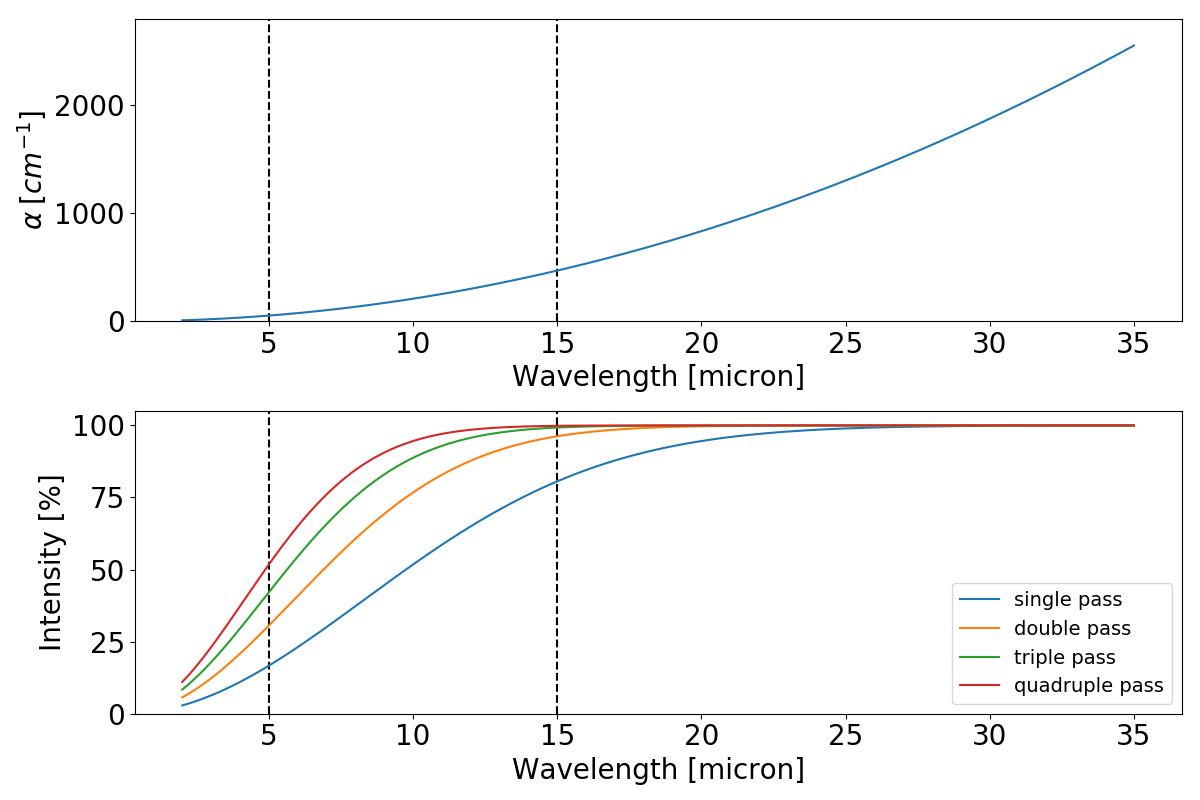

In [27]:
active_layer_thickness = 0.0035 # cm
wavelength_range = np.linspace(2,35,1000) # um
abs_coefficient = 102.*(wavelength_range/7.)**2
intensity_singlepass = 1-np.exp(-abs_coefficient*active_layer_thickness)
intensity_doublepass = 1-np.exp(-abs_coefficient*(2.*active_layer_thickness))
intensity_triplepass = 1-np.exp(-abs_coefficient*(3.*active_layer_thickness))
intensity_quadruplepass = 1-np.exp(-abs_coefficient*(4.*active_layer_thickness))

fig,axs = plt.subplots(2,1,figsize=(12,8))
axs[0].plot(wavelength_range,abs_coefficient)
axs[0].vlines([5,15],0,2800,linestyle='dashed')
axs[0].set_ylim(0,2800)
axs[0].set_ylabel(r'$\alpha \; [cm^{-1}]$')
axs[1].plot(wavelength_range,intensity_singlepass*100.,label='single pass')
axs[1].plot(wavelength_range,intensity_doublepass*100.,label='double pass')
axs[1].plot(wavelength_range,intensity_triplepass*100.,label='triple pass')
axs[1].plot(wavelength_range,intensity_quadruplepass*100.,label='quadruple pass')
axs[1].vlines([5,15],0,105,linestyle='dashed')
axs[1].set_ylim(0,105)
axs[1].set_ylabel('Intensity [%]')
axs[1].legend()
for plot in range(2): axs[plot].set_xlabel('Wavelength [micron]')
plt.tight_layout()

### Remarks:
* How much light is absorbed with each pass through the active layer?
    * When the photons travel the geometric thickness of the active layer once ("single pass") 16.6% of the incoming light is absorbed.
    * When the photons travel the geometric thickness of the active layer once, in one direction, then are reflected off the aluminium surrounding the pixels and travel through the active layer a second time in the opposite direction ("double pass") 30.5% of the light is absorbed.
    * If the photons are reflected once more on the buried contact, then we talk about a "triple pass", and we estimate that 42% of the light will be absorbed by the active layer.
    * For a quadruple pass 51.8% of the light is absorbed.

What do all these percentages mean? First of all any estimation for the intensity above "double pass" is wrong, simply based on the fact that the reflectivity of the surface opposite the aluminium metallization is comparatively much smaller. The reflectivity of the buried contact is extremely small (~0.36% at 5um), and the reflectance of the anti-reflection coating similarly so (~7.7% at 5um). It is implied here that a large amount of light exits the system after single pass, by virtue of not being reflected "back in", and thus can no longer be measured by the detector. Nevertheless, *some* light will be reflected onto the buried contact after single pass, and *some* light will be reflected on the anti-reflection coating. These marginal contribution will affect the residual beating pattern.
* Interestingly, above 15um, we expect most of the photons (~96%) to be converted into electron-hole pairs and phonons (/lattice vibrations) in the active-layer with a double pass. This means that the dominant fringe is likely to switch from the full 1710um cavity to the 1580um cavity. This switch is expected to be gradual (rather than abrupt), which makes things a tad more complicated, as the wavelength dependency of the extinction coefficient also needs to be taken into account when analyzing different MRS spectral bands.

## Conclusions:  
* Scanning the fringe transmission has allowed us to determine how the effective reflectivity and optical thickness equivalent to the high-frequency fringe vary in wavenumber space. 
* We assume that the optical thickness profile should be approximately flat for detector layers that are plane parallel. This assumption has allowed us to distinguish a low-order variation of the detector optical thickness. We have attributed this "non-flatness" to the warping of the chip on the wafer.
* Correcting for the high-frequency fringe in the data leaves a beating fringe in the residuals of the fringe-calibrated data. The beating is attributed to interference between:
    * the anti-reflection coating and the buried contact.
    * the buried contact and the pixel metallization.
* We find the effective reflectivity of the asymmetric etalon between the anti-reflection coating and the buried contact to match the beating amplitude seen in the data. We cannot omit a possible contribution to the beating from the interference between the buried contact and the pixel metallization.
* The absorption in the active layer of the MIRI detectors affects the amount of light reflected after each pass through the detector. As such it is difficult to relate the reflectivity seen for instance in the high-frequency fringes to an effective reflectivity measured from material properties. To complete the story here, for the high frequency fringe (cavity between anti-reflection coating and pixel metallization), the effective reflectivity is expected to be $R_{eff} = \sqrt{R_{ARcoat}\cdot R_{Al}} = \sqrt{0.077\cdot 0.98} = 0.275 = 27.5\%$. We measure, an effective reflectivity of $3.5\%$, in the point source data. This difference is quite large, but to verify it one would need to take into account the individual reflectivities of the different detector interfaces, as well as the absorption of the active layer.

## Follow-up question:  
Can we incorporate everything that we have learned into an optical model for the detector? This model would be using the optical properties and the geometric thicknesses of the detector layers as inputs, yielding a value for the transmittance, reflectance, and absorptance of the full detector.